## ***Análisis exploratorio de los datos***

### ***Descripción del Notebook***

En este notebook se formula el problema y se presenta la descripción técnica de la base de datos *Apnea-ECG*. Se analizan las variables del archivo **features_with_metaData**, llevando a cabo una exploración inicial de distribuciones, patrones y correlaciones relevantes. 

Como parte del preprocesamiento, se eliminan los registros en los que **SpO₂ = 0**, ya que corresponden a desconexiones o fallos del sensor y no aportan información útil. El dataframe depurado resultante se almacena y constituye la base para las etapas posteriores.

# <span style="color:#1a73e8;"><strong>📘 Proyecto de Ciencia de Datos</strong></span>


Nataly Rodriguez Atehortua - nataly.rodriguez1@udea.edu.co

## <span style="color:#1a73e8;"><strong>Preparación de la fuente de datos y librerías</strong></span>

In [1]:
# librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import warnings
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.stats import zscore


## <span style="color:#1a73e8;"><strong>Formulación del problema</strong></span>

La apnea obstructiva del sueño (AOS) es un trastorno respiratorio altamente prevalente, caracterizado por episodios recurrentes de obstrucción parcial o completa del flujo respiratorio durante el sueño [1]. Según los criterios diagnósticos de la American Academy of Sleep Medicine (AASM), un evento se clasifica como apnea cuando la señal de flujo se reduce en ≥90 % por al menos 10 s [2], mientras que la hipopnea corresponde a una disminución ≥30 % acompañada de una desaturación ≥4 % [2]. 

Durante los últimos años, la carga epidemiológica de la AOS ha adquirido relevancia tanto a nivel nacional como internacional. En Colombia, entre 2017 y 2021, se registraron 363.204 diagnósticos, lo que equivale a una prevalencia de 21,67 por cada mil habitantes mayores de 50 años, con mayor concentración en Bogotá, Cundinamarca, Antioquia y Valle del Cauca [3]. A nivel global, se estima que alrededor de 936 millones de adultos entre 30 y 69 años presentan esta condición, reflejando un problema de salud pública subdiagnosticado [4].

Los dispositivos de presión positiva automática (APAP) detectan estos eventos a partir de descensos en la amplitud del flujo respiratorio mediante comparaciones entre ventanas de corta y larga duración. Aunque los principios generales se basan en umbrales, cada fabricante implementa variantes propias en el procesamiento de la señal; por ejemplo, ResMed™ analiza un flujo filtrado y escalado mediante métricas basadas en el valor cuadrático medio (RMS) [5]. A pesar de que los algoritmos basados en umbrales continúan siendo el núcleo funcional de los sistemas APAP, investigaciones recientes demuestran que técnicas de machine learning y deep learning permiten mejorar la detección de eventos. Estos modelos integran múltiples señales fisiológicas —como flujo respiratorio, variabilidad cardíaca derivada del ECG y saturación de oxígeno (SpO₂)— para capturar patrones no lineales, dinámicas temporales y transiciones sutiles entre respiración normal y eventos obstructivos [6] [7].


### ***Objetivos***

El presente trabajo se orienta a identificar patrones fisiológicos que permitan distinguir de forma consistente entre épocas con y sin eventos respiratorios empleando únicamente características simples derivadas de tres señales accesibles: flujo respiratorio, variabilidad cardíaca y saturación de oxígeno. El objetivo es comprender qué variables, o combinaciones de ellas, ofrecen una mayor capacidad discriminante, constituyendo así una base sólida para el desarrollo posterior de algoritmos de detección más robustos y adaptables. Desde esta perspectiva, la pregunta central que guía este estudio es: ¿qué patrones fisiológicos pueden revelarse a partir de características simples extraídas de señales de flujo, ECG y SpO₂, y en qué medida dichas características permiten diferenciar épocas etiquetadas con apnea o hipopnea de aquellas sin eventos?

### ***Relevancia análitica del problema***

La relevancia analítica de este enfoque radica en que la identificación de patrones fisiológicos a partir de señales simples representa un componente crítico en el diseño de futuros sistemas de detección automática, particularmente en el contexto de dispositivos APAP y plataformas portátiles de monitoreo del sueño. Antes de avanzar hacia modelos predictivos complejos o arquitecturas basadas en aprendizaje profundo, resulta indispensable caracterizar el comportamiento real de estas señales, evaluar la estabilidad de sus métricas y determinar qué variaciones corresponden a fenómenos fisiológicos y cuáles a artefactos o errores de registro.

## <span style="color:#1a73e8;"><strong>Descripción de la base de datos</strong></span>


<b> 1. Número de registros</b><br>

Este proyecto utiliza la base de datos **[Apnea-ECG](https://physionet.org/content/apnea-ecg/1.0.0/) [8]** disponible en PhysioNet. Esta base de datos recopila información de 8 registros con una duración entre 7 y 10 horas cada uno. Las señales disponibles incluyen:

- **ECG**
- **Saturación de oxígeno (SpO₂)**
- **Flujo oro-nasal** (medido mediante termistores)

Cada registro fue segmentado en épocas de 60 segundos, las cuales están etiquetadas según la presencia o ausencia de eventos respiratorios. Las etiquetas se codifican como:

- "A": presencia de un evento de apnea al inicio de la época.
- "N": ausencia de eventos de apnea.

Esta segmentación de 1 minuto, permite un análisis temporal consistente con los criterios diagnósticos estándar de la apnea obstructiva del sueño (≥10 segundos de cese respiratorio o reducción del flujo acompañada de desaturación ≥3%) [9].

<b> 2. Descripción de las señales.</b><br>

En la Figura 1 se presentan las señales de SpO2, flujo y ECG, junto con la detección de los picos R durante una época sin eventos de apnea (etiquetada como N). Por su parte, la Figura 2 muestra las mismas señales correspondientes a una época con eventos de apnea (etiquetada como A).

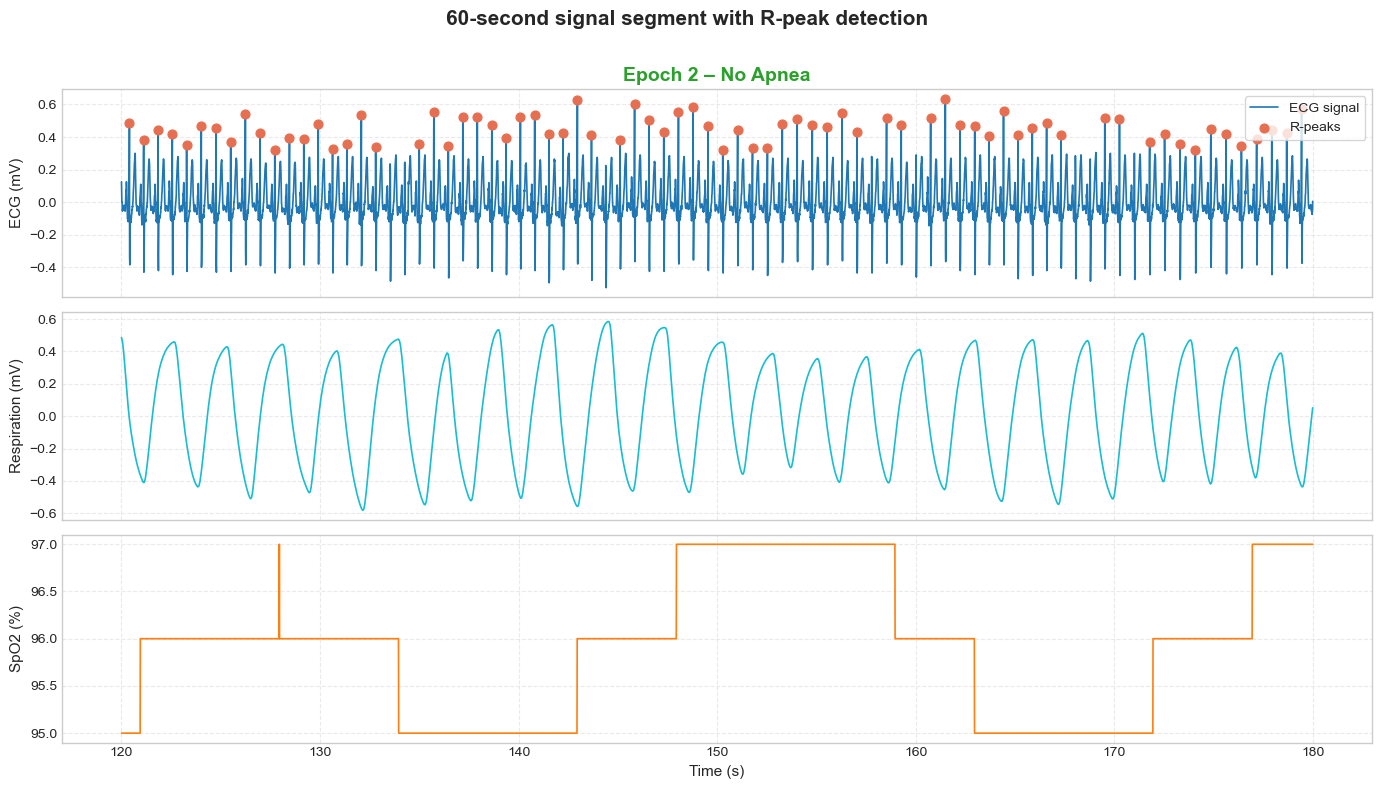

**Figura 1.** Época sin evento de apnea 

<br><br>

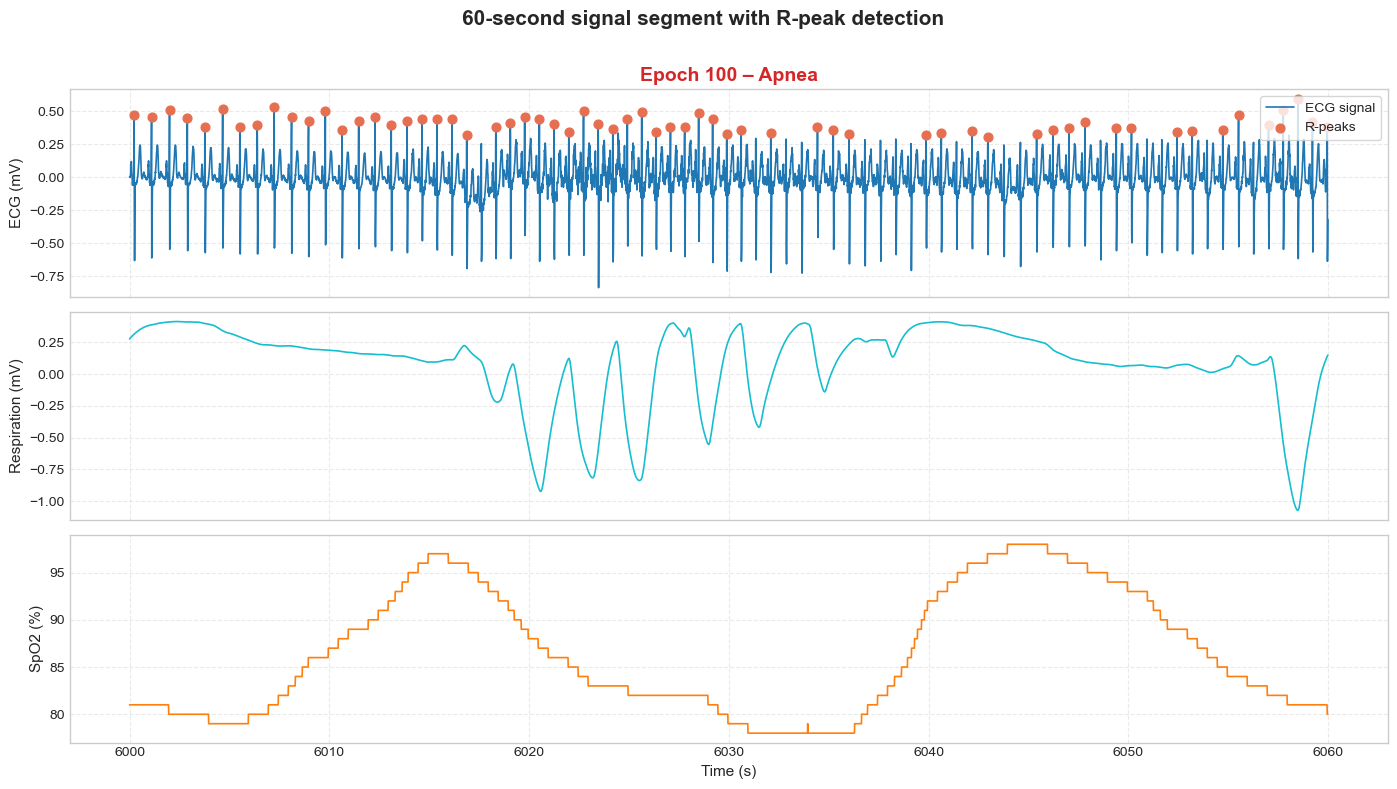

**Figura 2.** Época con evento de Apnea

En la figura correspondiente al evento de apnea (Figura 2) se observa una interrupción del flujo respiratorio, evidenciada por la ausencia de oscilaciones en la señal de flujo oro-nasal. Este patrón se asocia con una caída transitoria en la saturación de oxígeno (SpO₂), lo cual refleja la hipoxemia característica de los eventos apneicos. En contraste, la época sin evento (Figura 1) exhibe señales más estables, con variabilidad fisiológica normal y sin desaturaciones notorias.

<b> 3. Características extraídas.</b><br>

A partir de cada una de las señales segmentadas recopiladas en el DataSet, se extrajeron características relevantes en el dominio temporal y frecuencial:

### ***Señal ECG***:
- **Dominio temporal**: promedio, mediana, varianza, RMSSD (raíz cuadrada de la media de las diferencias cuadráticas sucesivas), desviación estándar, varianza del cociente entre RR consecutivos

- **Dominio frecuencial (HRV)**: Razón entre las bandas de baja frecuencia (LF: 0.04–0.15 Hz) y alta frecuencia (HF: 0.15–0.40 Hz), expresada como LF/HF.

### ***Señal SpO₂***:
- **Dominio temporal**: promedio, desviación estándar, varianza, valor mínimo y máximo por época.

### ***Señal de flujo respiratorio***:
- **Dominio temporal**: promedio, mediana y desviación estándar.
- **Dominio frecuencial**: densidad espectral de potencia (PSD) y medias del espectro en los rangos 0–0.1 Hz y 0.4–0.5 Hz (`mean_PSD0_0.1` y `mean_PSD0.4_0.5`).

Todas las características extraídas por épocas de 60 segundos, junto con la información de género de los 8 sujetos, fueron consolidadas en un archivo `.csv` denominado **`features_with_metaData.csv`**. En este archivo:

- Cada **fila** corresponde a una época (minuto) de señal procesada.
- Cada **columna** representa una característica extraída.
- Se incluye una columna llamada **`subject`** que identifica a qué registro/sujeto pertenece cada muestra.
- Se añaden la columna **`sex`**, que indica el sexo de cada sujeto.
- Se añade la columna de **etiquetas (`label`)** proveniente de la base de datos original:
  - `"A"` indica que al inicio del minuto hay un evento de **apnea**.
  - `"N"` indica que **no** hay un evento de apnea.

### Distribución de clases:
- `N` (sin apnea): 2311 instancias  
- `A` (con apnea): 1587 instancias

### Total de características 

El dataset presentado contiene un total de **3.898 filas** y **20 variables (columnas)**.

<b> 4. Tipos de datos.</b><br>

### Tipos de datos por variable:
- **float64 (17 columnas):** Corresponden a las características extraídas de cada señal segmentada.  
- **object (3 columnas):** Incluyen:
  - `sex`: Género del sujeto.
  - `label`: Etiqueta que indica la presencia o ausencia de un evento de apnea.
  - `subject`: Identificador único del sujeto. 


<b> 5. Tabla descriptiva de las variables</b><br>

| Nombre de la variable | Tipo | Definición | Referencia |
|------------------------|-------|-------------|-------------|
| mean_rr | Numérica | Promedio de los intervalos RR en una época de 60 s; refleja el ritmo cardíaco promedio. | [10] |
| median_rr | Numérica | Mediana de los intervalos RR; representa el valor central del ritmo cardíaco y reduce la influencia de valores atípicos. | [10] |
| var_rr | Numérica | Varianza de los intervalos RR; cuantifica la dispersión estadística de los intervalos RR, reflejando la variabilidad del ritmo cardíaco | [10] |
| std_rr | Numérica | Desviación estándar de los intervalos RR; cuantifica la variabilidad general del ritmo cardíaco. | [10] |
| RMSSD | Numérica | Raíz cuadrada de la media de las diferencias cuadráticas sucesivas entre intervalos RR; índice sensible a la modulación parasimpática del corazón. | [10] |
| var_RR_ratio | Numérica | Varianza del cociente entre intervalos RR consecutivos; refleja la irregularidad o inestabilidad del ritmo cardíaco. | [11] |
| LF_HF_ratio | Numérica | Razón entre las potencias espectrales en bajas (0.04–0.15 Hz) y altas frecuencias (0.15–0.4 Hz); estima el equilibrio entre la actividad simpática y parasimpática. | [10] |
| mean_SpO2 | Numérica | Valor promedio de la saturación de oxígeno en la época. | [11] |
| std_SpO2 | Numérica | Desviación estándar de la SpO₂; refleja variabilidad de oxigenación. | [11] |
| var_SpO2 | Numérica | Varianza de la SpO₂; mide la dispersión de los valores de saturación. | [11] |
| min_SpO2 | Numérica | Valor mínimo de saturación de oxígeno. | [11] |
| max_SpO2 | Numérica | Valor máximo de saturación de oxígeno durante la época. | [11] |
| mean_flow | Numérica | Promedio del flujo oro-nasal; representa la ventilación media. | [12] |
| median_flow | Numérica | Mediana del flujo respiratorio; refleja el valor central del flujo | [12] |
| std_flow | Numérica | Desviación estándar del flujo respiratorio; indica variabilidad ventilatoria. | [12] |
| mean_PSD0_0.1 | Numérica | Media del espectro de potencia en el rango 0–0.1 Hz; asociada con respiración lenta o eventos apneicos. | [12] |
| mean_PSD0.4_0.5 | Numérica | Media del espectro de potencia en 0.4–0.5 Hz; representa ventilación normal y ciclos respiratorios regulares. | [12] |
| Sex | Categórica | Sexo biológico del sujeto (M/F). |  |
| label | Categórica | Etiqueta de clase: “A” (apnea) o “N” (normal). | |


En las señales analizadas se espera observar diferencias fisiológicas entre las épocas con y sin apnea. En cuanto a la variabilidad cardíaca, la varianza de los intervalos RR tiende a disminuir en los pacientes con apnea del sueño. No obstante, hacia el final de los episodios de apnea o hipopnea suele evidenciarse un incremento tanto en la potencia de baja frecuencia (LF) como en la potencia total (TF) del espectro de variabilidad de la frecuencia cardíaca, fenómeno asociado a la activación simpática y a la recuperación del ritmo respiratorio [13].

En el caso de la saturación de oxígeno (SpO₂), se observa una disminución progresiva durante los episodios de apnea o hipopnea, seguida de una recuperación. Este patrón refleja los ciclos repetitivos de desaturación y reoxigenación característicos del síndrome de apnea del sueño. Es importante destacar que la caída en la saturación no ocurre de forma inmediata tras el inicio del evento apneico, sino que presenta un retraso de aproximadamente 10 a 40 segundos, debido al tiempo fisiológico necesario para que los niveles de oxígeno en sangre arterial disminuyan de manera perceptible [14].

Asimismo, los eventos de apnea se caracterizan por disminuciones recurrentes del flujo respiratorio a lo largo de la noche. Este comportamiento fundamentó el proceso de extracción de características en el que se calcularon la media, la mediana y la desviación estándar como métricas en el dominio temporal. Adicionalmente, considerando que la señal de flujo respiratorio es inherentemente no estacionaria, se aplicó el método de Welch para estimar la densidad espectral de potencia (PSD), lo que permitió identificar los componentes frecuenciales asociados tanto a la respiración normal como a las alteraciones propias de los eventos de apnea [12].

In [2]:
# DataFrame 
df = pd.read_csv('../datos/features_with_metaData.csv')
df.head()

,spo2_mean,spo2_std,spo2_var,spo2_min,spo2_max,airflow_mean,airflow_median,airflow_std,airflow_mean_PSD_0_0.1,airflow_mean_PSD_0.4_0.5,mean_rr,median_rr,var_rr,rmssd,std_rr,var_rr_ratio,hrv_lf_hf_ratio,label,subject,Sex
0,96.701000,1.695563,2.874932,93,98,0.030024,0.057825,0.184668,0.041587,0.005301,0.900000,0.90,0.003503,0.041658,0.059186,0.002146,1.282583,N,a01,M
1,97.350000,0.678602,0.460500,96,98,0.022421,0.026675,0.138686,0.020508,0.009239,0.838714,0.84,0.002114,0.037879,0.045979,0.002096,1.238604,N,a01,M
2,98.368667,0.773575,0.598418,97,100,0.037414,0.113125,0.324112,0.235710,0.003447,0.811644,0.80,0.006471,0.042525,0.080444,0.002758,1.030521,N,a01,M
3,99.000000,0.000000,0.000000,99,99,0.002367,0.009575,0.261016,0.106126,0.007442,0.748101,0.76,0.003684,0.027712,0.060694,0.001384,2.982284,N,a01,M
4,98.132833,0.426054,0.181522,97,99,0.020547,0.058950,0.175053,0.076721,0.005316,0.794667,0.79,0.002158,0.031365,0.046457,0.001563,4.459743,N,a01,M


In [3]:
# --- DataFrame info ---
print("=== DataFrame Info ===")
df.info()

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   spo2_mean                 3898 non-null   float64
 1   spo2_std                  3898 non-null   float64
 2   spo2_var                  3898 non-null   float64
 3   spo2_min                  3898 non-null   int64  
 4   spo2_max                  3898 non-null   int64  
 5   airflow_mean              3897 non-null   float64
 6   airflow_median            3897 non-null   float64
 7   airflow_std               3897 non-null   float64
 8   airflow_mean_PSD_0_0.1    3897 non-null   float64
 9   airflow_mean_PSD_0.4_0.5  3897 non-null   float64
 10  mean_rr                   3895 non-null   float64
 11  median_rr                 3895 non-null   float64
 12  var_rr                    3888 non-null   float64
 13  rmssd                     3888 non-null 

<b>Conteo de valores, tipos de datos y valores faltantes.</b><br>

In [4]:
# --- Valores Null por columna ---
print("\n=== Null Values per Column ===")
# Conteo de valores faltantes ordenado de mayor a menor
faltantes = df.isnull().sum().sort_values(ascending=False)

print("\nConteo de valores faltantes por variable:")
print(faltantes[faltantes > 0])


=== Null Values per Column ===

Conteo de valores faltantes por variable:
hrv_lf_hf_ratio             20
var_rr_ratio                17
std_rr                      10
var_rr                      10
rmssd                       10
mean_rr                      3
median_rr                    3
airflow_mean                 1
airflow_median               1
airflow_std                  1
airflow_mean_PSD_0_0.1       1
airflow_mean_PSD_0.4_0.5     1
dtype: int64


In [5]:
# --- Eliminación de registros con SpO2 mínima igual a cero ---
filas_antes = len(df)
df = df[df["spo2_min"] > 0].reset_index(drop=True)
filas_despues = len(df)
print(f"\nSe eliminaron {filas_antes - filas_despues} filas donde SpO2_min = 0.")
print(f"Total de filas finales: {filas_despues}")


Se eliminaron 106 filas donde SpO2_min = 0.
Total de filas finales: 3792


In [6]:
# Guardar variables imputadas
path = "../datos/features_iniciales.csv"

df.to_csv(path, index=False)

### ***Análisis***

Se excluyeron los registros en los que la variable SpO2 min presentaba un valor de 0, ya que estos reflejan la desconexión del sensor de saturación de oxígeno durante la época correspondiente.  

Tras esta depuración inicial, el conjunto de datos quedó conformado por 3,792 filas, equivalentes al mismo número de épocas. El resultado de este proceso se almacenó en el dataframe features_iniciales, que servirá como base para los análisis desarrollados en los notebooks posteriores.

## <span style="color:#1a73e8;"><strong>Análisis descriptivo</strong></span>

In [7]:
# --- Estadísticas descriptiva ---
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

desc_stats = df.describe()

# Coeficiente de variación
cv = desc_stats.loc['std'] / desc_stats.loc['mean']
cv.name = 'cv'

# Agregar a la tabla
desc_stats = pd.concat([desc_stats, cv.to_frame().T])

print("\n=== Descriptive Statistics with Coefficient of Variation ===")
display(desc_stats)


=== Descriptive Statistics with Coefficient of Variation ===


,spo2_mean,spo2_std,spo2_var,spo2_min,spo2_max,airflow_mean,airflow_median,airflow_std,airflow_mean_PSD_0_0.1,airflow_mean_PSD_0.4_0.5,mean_rr,median_rr,var_rr,rmssd,std_rr,var_rr_ratio,hrv_lf_hf_ratio
count,3792.000000,3792.000000,3792.000000,3792.000000,3792.000000,3791.000000,3791.000000,3791.000000,3791.000000,3791.000000,3790.000000,3790.000000,3783.000000,3783.000000,3783.000000,3777.000000,3774.000000
mean,91.341776,2.914003,19.425745,86.098892,95.752637,-0.000324,0.008039,0.204491,0.035042,0.036344,1.007237,0.967475,0.404870,0.203545,0.181000,0.159053,2.877784
std,5.946734,3.307146,40.743621,11.569363,2.862725,0.049249,0.100994,0.092986,0.042934,0.063806,0.596795,0.514951,8.422598,0.936965,0.610088,2.262560,4.838954
min,52.468833,0.000000,0.000000,1.000000,74.000000,-0.131957,-0.192750,0.044301,0.000394,0.000000,0.561667,0.525000,0.000025,0.007022,0.005000,0.000077,0.000000
25%,88.990083,0.464979,0.216205,79.000000,95.000000,-0.044728,-0.083788,0.126254,0.005296,0.005659,0.887463,0.840000,0.003140,0.034876,0.056040,0.001309,0.758485
50%,94.434083,0.820425,0.673102,92.000000,96.000000,-0.026594,-0.020275,0.192728,0.017375,0.013646,0.963658,0.950000,0.009262,0.067880,0.096241,0.004431,1.623789
75%,95.417333,5.379366,28.937580,95.000000,97.000000,0.042815,0.090888,0.263292,0.051818,0.034525,1.049420,1.040000,0.026538,0.144253,0.162905,0.019387,3.473889
max,99.000000,34.221616,1171.119029,99.000000,100.000000,0.159641,0.294750,0.605357,0.434127,0.617125,26.875000,26.875000,369.568689,35.130000,19.224169,108.705687,192.021985
cv,0.065104,1.134915,2.097403,0.134373,0.029897,-151.919504,12.562530,0.454720,1.225225,1.755615,0.592507,0.532263,20.803193,4.603226,3.370647,14.225199,1.681486


### ***Análisis***

Se realizó un análisis descriptivo de las variables numéricas del conjunto de datos, evaluando tendencias centrales, dispersión y posibles valores atípicos. En términos generales, se observa que algunas variables presentan una alta variabilidad y valores extremos que exceden considerablemente la media, lo que podría reflejar episodios fisiológicos atípicos o errores puntuales en la medición.

Por ejemplo, la variable spo2_var muestra una media de 19.4 y un valor máximo de 1171.12, indicando una dispersión considerable en la variabilidad del nivel de saturación de oxígeno. Esto sugiere que algunas épocas presentan fluctuaciones extremas en SpO₂, aunque la mayoría de los valores se concentran en rangos fisiológicamente esperables.

De manera similar, varias características derivadas de los intervalos RR, como var_rr, rmssd y hrv_lf_hf_ratio, presentan valores máximos que superan ampliamente la media, reflejando distribuciones altamente asimétricas y la presencia de posibles valores atípicos.

En contraste, variables como spo2_mean, spo2_min y spo2_max muestran menor dispersión, con valores concentrados en rangos esperados para parámetros fisiológicos normales. 

Considerando los valores del coeficiente de variación, se observa que variables como spo2_mean y spo2_max presentan un CV bajo (≈ 0.03–0.06), indicando que la dispersión relativa es pequeña y los valores están bastante concentrados alrededor de la media. Otras variables, especialmente spo2_var, airflow_mean_PSD_0.4_0.5 y var_rr, airflow_median presentan CV altos (> 2), reflejando una dispersión relativa muy elevada y la presencia de valores extremos. También se presentan algunos CV negativos o extremadamente grandes (como en airflow_mean) debido a que la media de la variable está cercana a cero, lo que exagera la relación entre desviación estándar y media

## <span style="color:#1a73e8;"><strong> (EDA) Visualizaciones exploratorias</strong></span>


### ***Visualización variables numéricas agrupadas según el estado: Apnea (A) o Sin evento (N)***

In [8]:
def boxplots_por_caracteristica(df, features, group_col):
    
    # Copiar datos para no modificar el original
    data = df.copy()
    
    # Normalizar las características seleccionadas al rango [0, 1]
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    
    data_long = data.melt(id_vars=group_col, value_vars=features,
                          var_name="Característica", value_name="Valor estandarizado")
    
    # Boxplot en un solo gráfico
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="Característica", y="Valor estandarizado", hue=group_col,
        data=data_long, palette="pastel"
    )
    
    plt.title("Boxplots normalizados por característica", fontsize=16, fontweight="bold")
    plt.xlabel("Características", fontsize=12)
    plt.ylabel("Valor estandarizado", fontsize=12)
    plt.xticks(rotation=30, ha="right")
    sns.despine()
    plt.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

### <span style="color:#1a73e8;"><strong> ECG</strong></span>

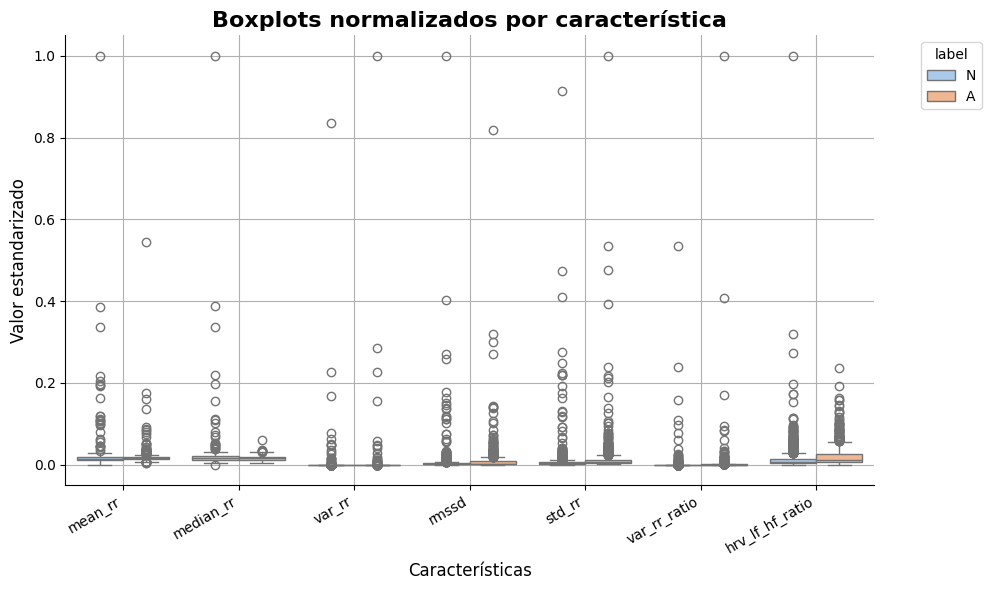

In [9]:
features = ['mean_rr','median_rr', 'var_rr','rmssd', 'std_rr', 'var_rr_ratio', 'hrv_lf_hf_ratio']  
boxplots_por_caracteristica(df, features, group_col="label")

### <span style="color:#1a73e8;"><strong>SPO2</strong></span>

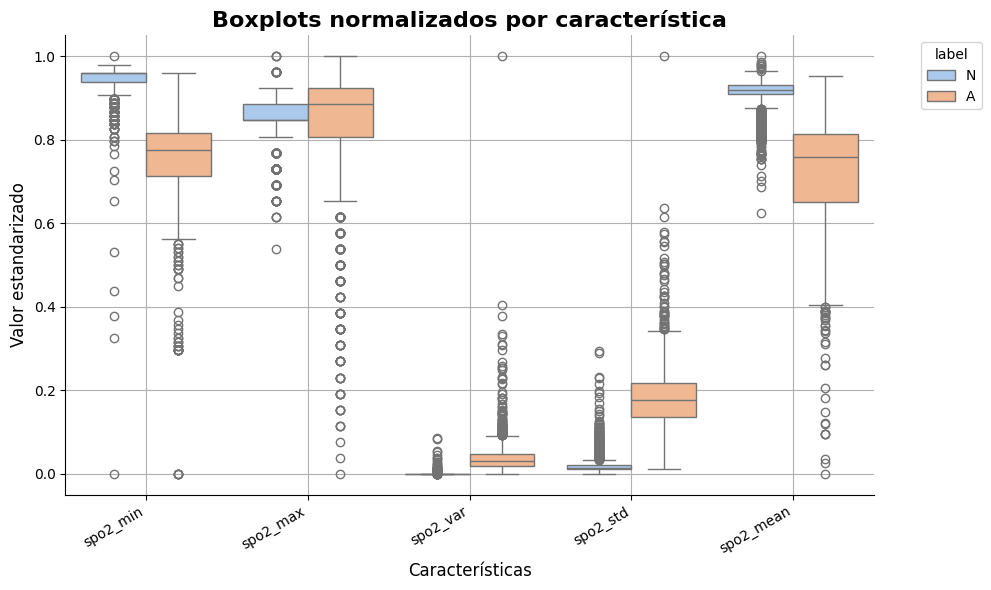

In [10]:
features = ['spo2_min','spo2_max','spo2_var','spo2_std','spo2_mean']  
boxplots_por_caracteristica(df, features, group_col="label")

### <span style="color:#1a73e8;"><strong>FLUJO</strong></span>

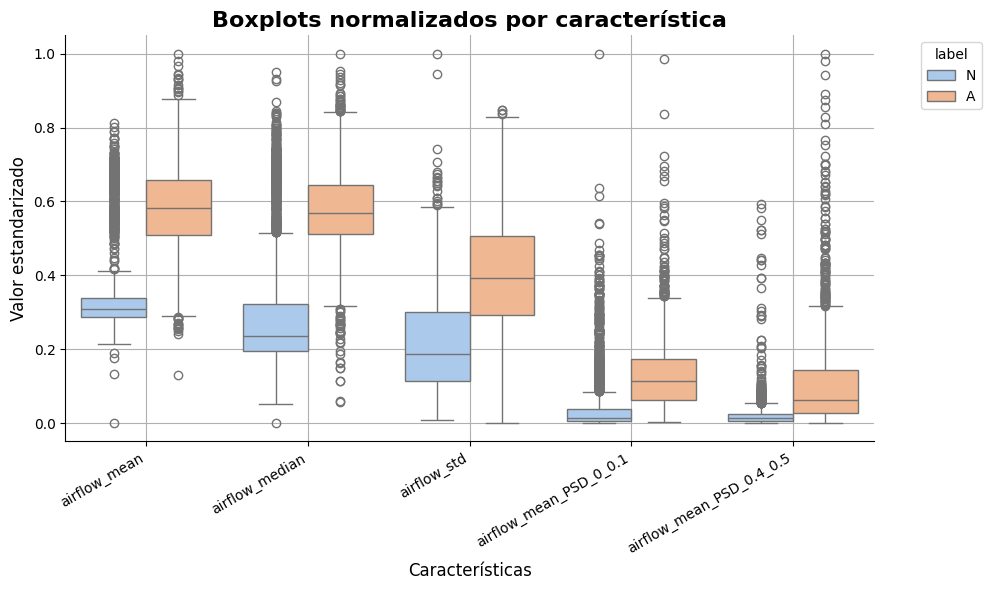

In [11]:
features = ['airflow_mean','airflow_median','airflow_std','airflow_mean_PSD_0_0.1','airflow_mean_PSD_0.4_0.5']  
boxplots_por_caracteristica(df, features, group_col="label")

#### ***Análisis***

Con el objetivo de analizar las variables por señal, se normalizó cada característica dentro de su respectivo grupo de señal y se dividieron los datos en los grupos de interés: apnea y no apnea. Para las características extraídas de la señal ECG mediante los picos R, se observa que la mediana, así como métricas de variabilidad como la varianza de los intervalos RR y el RMSSD, presentan valores bajos, sin diferencias apreciables entre los grupos. Además, se evidencia una presencia de numerosos valores atípicos, lo que podría reducir la sensibilidad de la mediana para reflejar diferencias entre condiciones. Estos resultados sugieren que, en este conjunto de datos, los episodios de apnea no generan cambios consistentes en las características del ritmo cardíaco, o que las variaciones fisiológicas asociadas se manifiestan de manera más sutil de lo que estas métricas permiten detectar.

En las características de SpO₂ se evidencian diferencias entre medianas. Para métricas como el valor mínimo y el promedio, se observa que la mediana es menor en las épocas con apnea en comparación con aquellas sin apnea, lo cual refleja la desaturación de oxígeno presente durante los eventos respiratorios. En contraste, las características que reflejan variabilidad, como la desviación estándar, presentan una mediana mayor en el grupo de épocas con apnea, debido a los cambios de desaturación y recuperación, mientras que en las épocas sin eventos estos valores se mantienen relativamente constantes. Para la característica del valor máximo, se observa una mayor dispersión en las épocas de apnea, aunque las medianas son similares entre ambos grupos, indicando que ambos tipos de épocas alcanzan valores máximos comparables.

En la señal de flujo respiratorio, las medianas de las características evaluadas son mayores en el grupo con apnea. Este aumento se explica porque, durante los eventos apneicos, el flujo permanece la mayor parte del tiempo en valores cercanos a cero, generando una concentración de puntos positivos en torno a ese nivel y desplazando las métricas de tendencia central hacia valores más altos. Por otro lado, las métricas asociadas a la variabilidad, como la desviación estándar, y las componentes espectrales en los rangos de 0–0.1 Hz y 0.4–0.5 Hz presentan valores mayores en las épocas con apnea. Esto refleja las fluctuaciones de flujo generadas por el cese y la posterior recuperación respiratoria, donde el esfuerzo inspiratorio compensatorio produce oscilaciones más marcadas en la señal. En contraste, durante las épocas sin eventos respiratorios, el flujo se mantiene más estable y dentro de un rango acotado (aproximadamente entre -0.6 y 0.6), reflejando un patrón respiratorio continuo

### ***Visualización de variables categóricas: sexo y etiqueta (Label)***

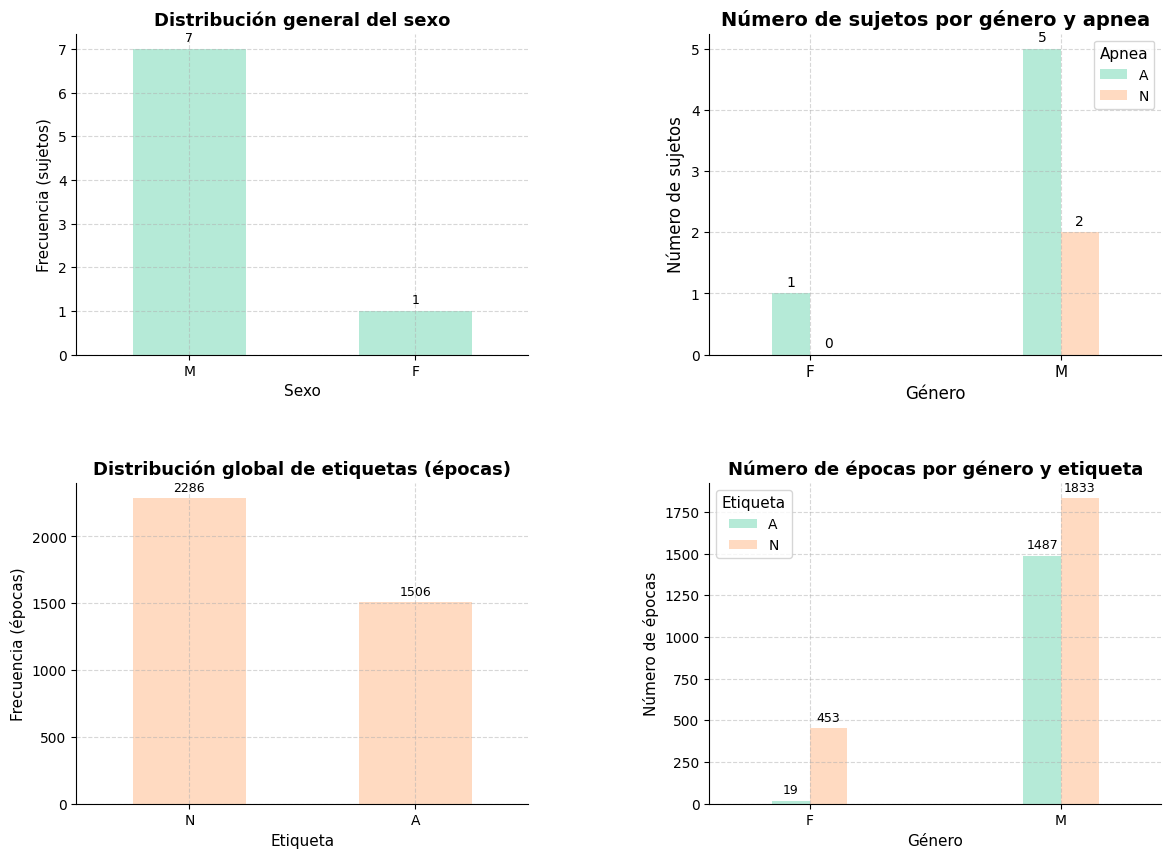

In [12]:
# --- Columnas relevantes ---
id_col = 'subject'
category_col = 'Sex'
label_col = 'label'

# --- Asegurar un registro único por sujeto ---
df_unique = df.drop_duplicates(subset=id_col)

# --- Clasificar cada sujeto según si tuvo al menos una apnea ---
subject_labels = (
    df.groupby(id_col)[label_col]
    .apply(lambda x: 'A' if (x == 'A').any() else 'N')
    .reset_index()
    .rename(columns={label_col: 'subject_label'})
)

# --- Unir con información de sexo ---
df_subject = pd.merge(df_unique[[id_col, category_col]], subject_labels, on=id_col, how='left')

# --- Conteos por sexo y presencia de apnea (por sujeto) ---
df_counts_subjects = df_subject.groupby([category_col, 'subject_label']).size().unstack(fill_value=0)

# --- Conteo general de sexo (por sujeto) ---
df_sex = df_subject[category_col].value_counts()

# --- Conteo de épocas por género ---
df_counts_epochs = df.groupby([category_col, label_col]).size().unstack(fill_value=0)

# --- Conteo global de etiquetas ---
df_labels = df[label_col].value_counts()

# --- Paleta de colores pastel ---
colors = ["#b5ead7", "#ffdac1"]

# --- Crear figura: 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# --- Gráfico 1: distribución general de sexo ---
df_sex.plot(kind='bar', color="#b5ead7", ax=ax1, width=0.5)
ax1.set_title("Distribución general del sexo", fontsize=13, fontweight="bold")
ax1.set_xlabel("Sexo", fontsize=11)
ax1.set_ylabel("Frecuencia (sujetos)", fontsize=11)
ax1.set_xticklabels(df_sex.index, rotation=0, fontsize=10)
for container in ax1.containers:
    ax1.bar_label(container, fmt="%d", fontsize=9, padding=3)

# --- Gráfico 2: sujetos por género y apnea ---
df_counts_subjects.plot(kind='bar', width=0.3, color=colors, ax=ax2)
ax2.set_title("Número de sujetos por género y apnea", fontsize=14, fontweight="bold")
ax2.set_xlabel("Género", fontsize=12)
ax2.set_ylabel("Número de sujetos", fontsize=12)
ax2.set_xticklabels(df_counts_subjects.index, rotation=0, fontsize=11)
ax2.legend(title="Apnea", fontsize=10, title_fontsize=11)
for container in ax2.containers:
    ax2.bar_label(container, fmt="%d", fontsize=10, padding=3)

# --- Gráfico 3: distribución global de etiquetas ---
df_labels.plot(kind='bar', color="#ffdac1", ax=ax3, width=0.5)
ax3.set_title("Distribución global de etiquetas (épocas)", fontsize=13, fontweight="bold")
ax3.set_xlabel("Etiqueta", fontsize=11)
ax3.set_ylabel("Frecuencia (épocas)", fontsize=11)
ax3.set_xticklabels(df_labels.index, rotation=0, fontsize=10)
for container in ax3.containers:
    ax3.bar_label(container, fmt="%d", fontsize=9, padding=3)

# --- Gráfico 4: número de épocas por género y etiqueta ---
df_counts_epochs.plot(kind='bar', width=0.3, color=colors, ax=ax4)
ax4.set_title("Número de épocas por género y etiqueta", fontsize=13, fontweight="bold")
ax4.set_xlabel("Género", fontsize=11)
ax4.set_ylabel("Número de épocas", fontsize=11)
ax4.set_xticklabels(df_counts_epochs.index, rotation=0, fontsize=10)
ax4.legend(title="Etiqueta", fontsize=10, title_fontsize=11)
for container in ax4.containers:
    ax4.bar_label(container, fmt="%d", fontsize=9, padding=3)


# --- Mejorar estética para todos los ejes ---
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.show()

#### ***Análisis***

Al analizar las variables categóricas género y etiqueta (label), se observa que de los ocho sujetos evaluados, siete corresponden al género masculino y uno al femenino, evidenciando un sesgo de distribución por género en la muestra. Entre los registros masculinos, cinco presentan al menos un evento de apnea, mientras que dos no registran eventos respiratorios. Por su parte, el registro femenino muestra la presencia de eventos de apnea.

En cuanto a las épocas, se identifican 2,286 sin eventos de apnea y 1,506 con eventos respiratorios. Desglosando por género, el registro de la mujer cuenta con 453 épocas sin apnea y 19 con eventos, mientras que los registros masculinos presentan un total de 1,833 épocas sin eventos respiratorios y 1,487 con eventos.

### ***Distribución y variabilidad de las variables cuantitativas según etiqueta (Label)***

In [13]:
def plot_variable_by_group(df, features, group_col, signal, num_bins=20):
    """
    Genera histogramas y boxplots para cada variable numérica,
    agrupados por una columna categórica.
    
    Parámetros:
    ------------
    df : pd.DataFrame
        DataFrame con los datos.
    features : list
        Lista de nombres de columnas numéricas a graficar.
    group_col : str
        Nombre de la columna categórica para agrupar.
   
    """

    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Crear mapa de colores 
    grupos_unicos = df[group_col].dropna().unique()
    colores_defecto = ["#A8E6CF", "#FFD3B6", "#FFAAA5", "#D5AAFF"]
    color_map = {grupo: colores_defecto[i % len(colores_defecto)] for i, grupo in enumerate(grupos_unicos)}

    # Título general
    print(f"\n\033[1mDISTRIBUCIÓN Y VARIABILIDAD DE LAS VARIABLES {signal} POR {group_col.upper()}\033[0m\n")

    # Graficar cada variable
    for col in features:

        fig, axes = plt.subplots(
            nrows=2,
            sharex=True,
            gridspec_kw={"height_ratios": [0.5, 1]},
            figsize=(10, 6)
        )

        # --- Boxplot (arriba) ---
        sns.boxplot(
            x=col,
            y=group_col,
            data=df,
            ax=axes[0],
            hue=group_col,
            palette=color_map,
            width=0.5,
            flierprops={'marker': 'o', 'color': 'black'},
            dodge=True
        )
        axes[0].set_ylabel("")
        axes[0].legend_.remove() if axes[0].get_legend() else None
        axes[0].grid(True, linestyle='--', alpha=0.6)

        # --- Histograma (abajo) ---
        sns.histplot(
            data=df,
            x=col,
            bins=num_bins,
            hue=group_col,
            palette=color_map,
            alpha=0.7,
            ax=axes[1],
            kde=True
        )
        axes[1].set_title(f"Distribución de {col} por {group_col}", fontsize=14, fontweight="bold")
        axes[1].set_xlabel("Valor", fontsize=12)
        axes[1].set_ylabel("Frecuencia", fontsize=12)
        axes[1].grid(True, linestyle='--', alpha=0.6)

        # Ajustar diseño
        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

### <span style="color:#1a73e8;"><strong> ECG</strong></span>


DISTRIBUCIÓN Y VARIABILIDAD DE LAS VARIABLES ECG POR LABEL



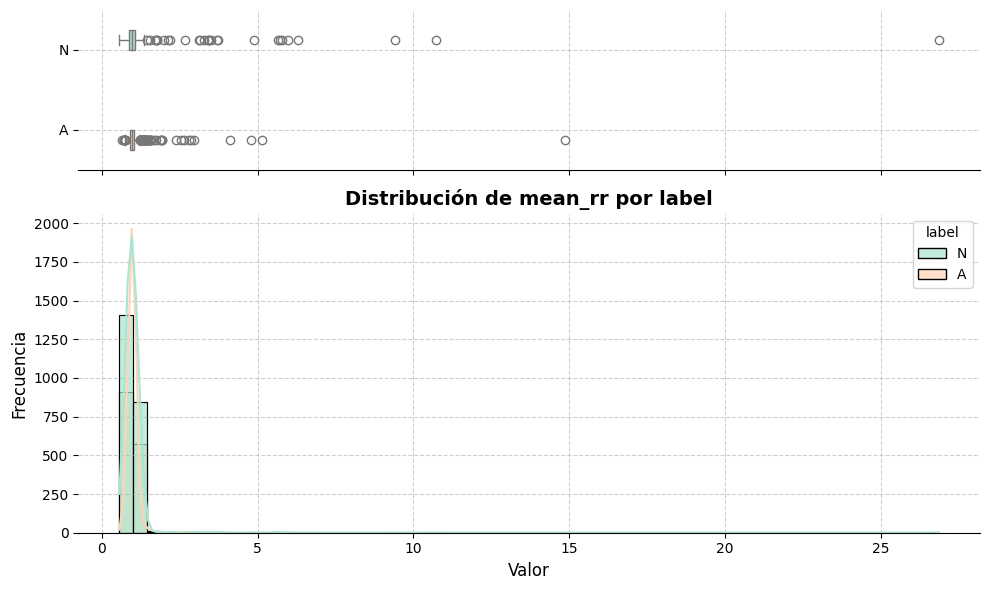

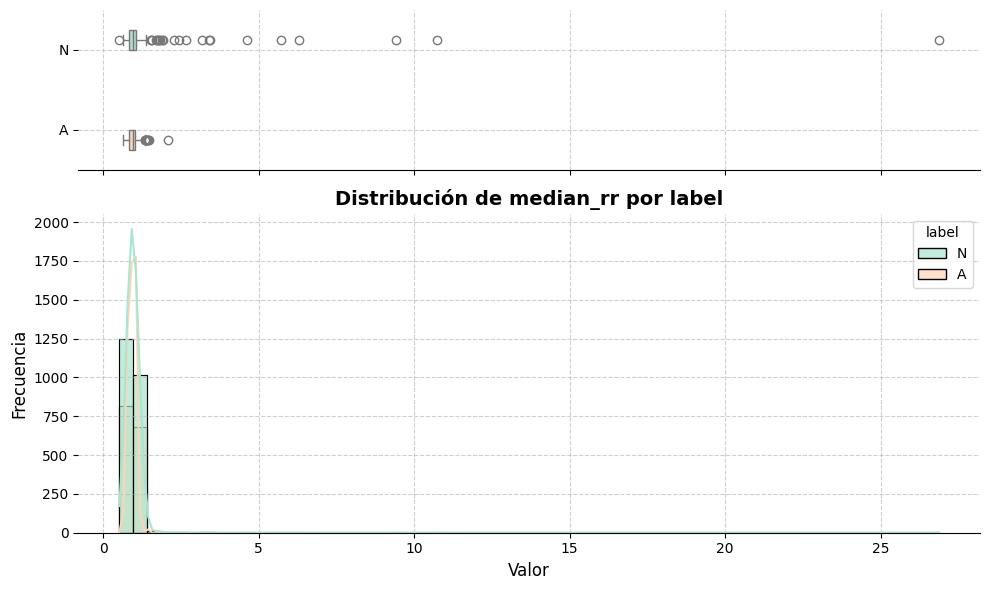

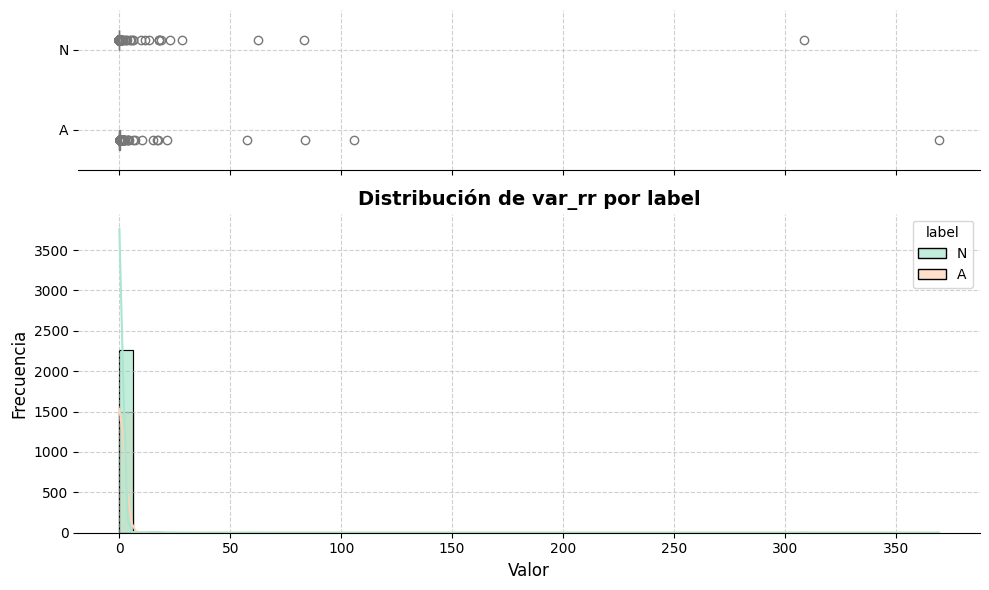

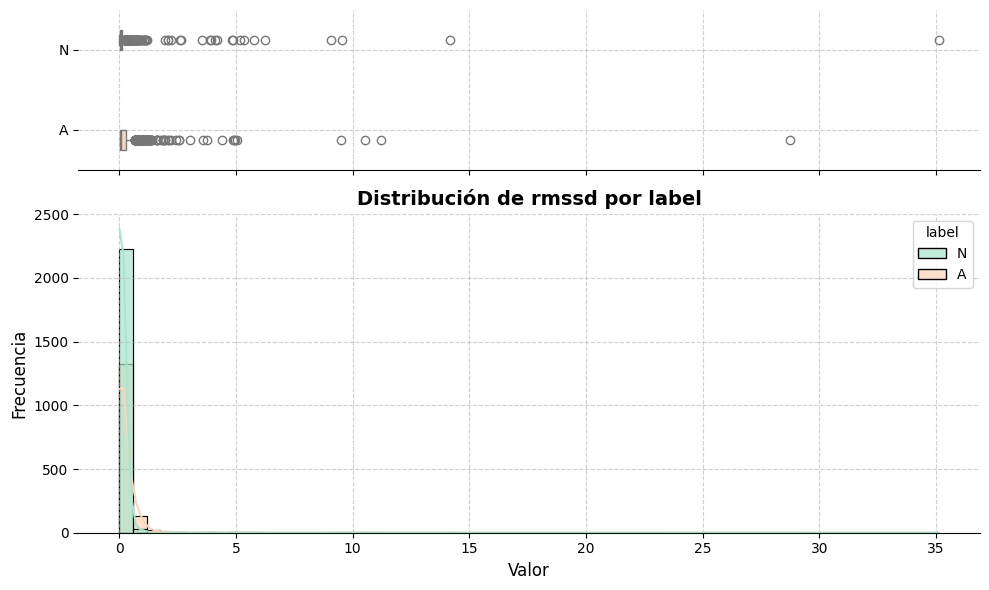

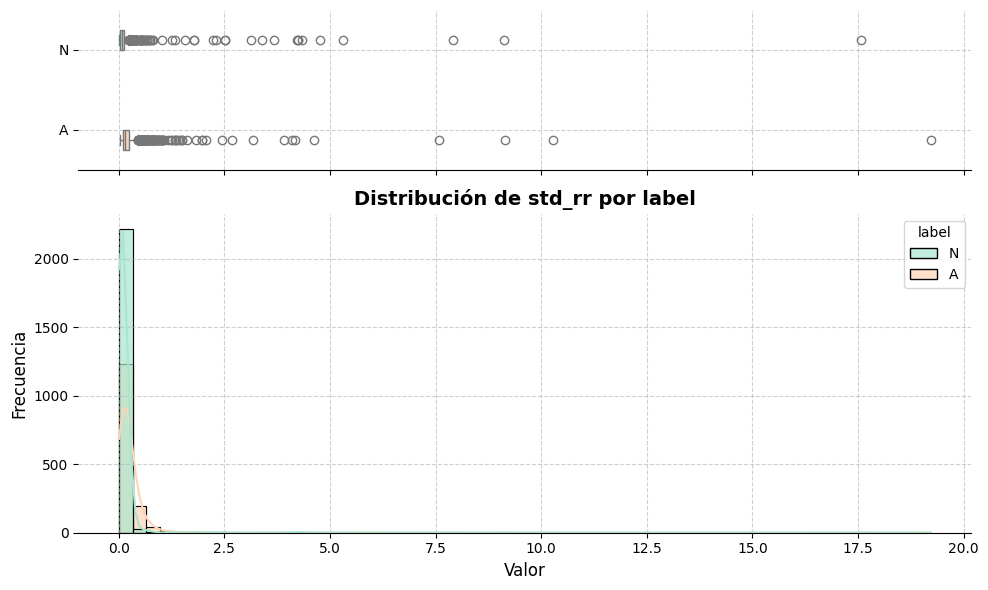

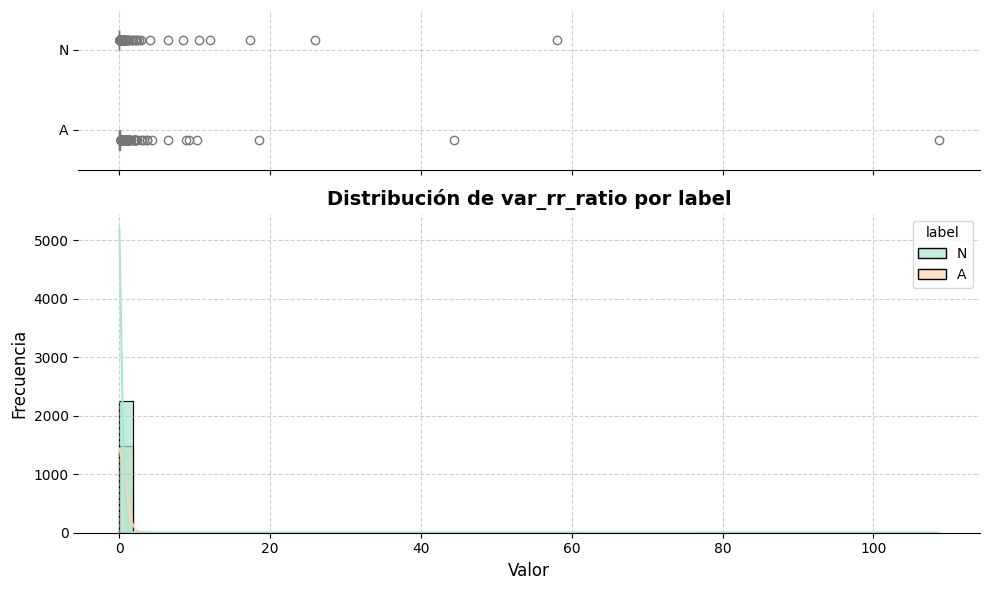

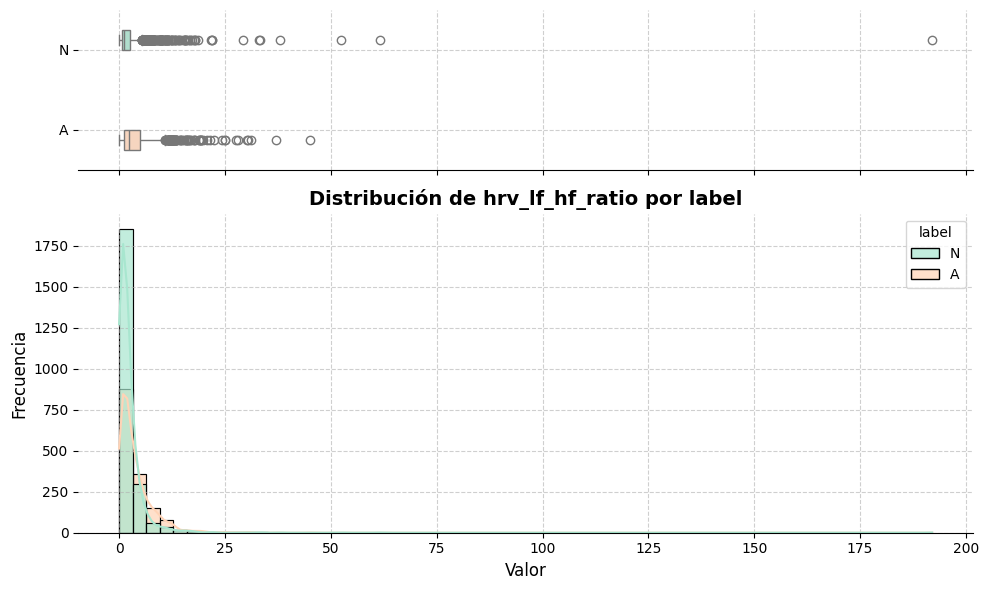

In [14]:
features = ['mean_rr','median_rr', 'var_rr','rmssd', 'std_rr', 'var_rr_ratio', 'hrv_lf_hf_ratio']  

plot_variable_by_group(df, features,'label', 'ECG', num_bins=60)

#### ***Análisis***

En el análisis bivariado de la señal de ECG se examinaron las características derivadas de los intervalos RR en relación con la variable de etiqueta (épocas con y sin eventos de apnea). Estas métricas se estimaron a partir de los picos R detectados mediante el algoritmo find_peaks. Este método permitió identificar la mayoría de los picos R presentes en la señal, como se ilustra en las Figuras 1 y 2; sin embargo, algunos picos de baja amplitud no fueron detectados, lo que representa una limitación en segmentos con morfología atenuada o baja relación señal-ruido.

A partir de los picos identificados, las medidas de tendencia central del intervalo RR, como mean_rr y median_rr, se concentraron alrededor de 1 s, correspondiente a una frecuencia cardíaca aproximada de 60 latidos por minuto, valor esperado durante el sueño. En condiciones fisiológicas normales, el intervalo R-R oscila entre 0.6 y 1 s, lo que equivale a una frecuencia cardíaca de 60 a 100 latidos por minuto [15]. Esta concordancia indica que la señal se mantiene fisiológicamente estable tanto en épocas con apnea como sin eventos respiratorios, lo que sugiere una adecuada calidad del registro y la ausencia de artefactos relevantes en la mayoría de los segmentos.

Por otro lado, las características de variabilidad, como var_rr, sd_rr y var_rr_ratio, muestran concentraciones cercanas a cero en ambos grupos, lo que indica que las diferencias entre intervalos consecutivos son pequeñas en general. Este patrón sugiere que, aunque los eventos de apnea pueden inducir variaciones puntuales, la señal de ECG mantiene estabilidad en sus oscilaciones globales y la variabilidad extrema es limitada.

En cuanto a las características espectrales, como hrv_lf_hf_ratio, los valores se concentran principalmente en rangos bajos, especialmente en torno a cero, en ambos grupos. Esto refleja un predominio relativo de las frecuencias bajas de la señal, que puede asociarse con la influencia parasimpática durante el sueño, y que no se ve alterada de manera significativa en el promedio por la presencia de apneas.

En conjunto, los resultados indican que las amplitudes de la señal RR se mantienen consistentes entre épocas con y sin apnea, mientras que la variabilidad de la señal y las relaciones espectrales presentan cambios leves. No obstante, varias características presentan valores atípicos que deben analizarse en etapas posteriores, ya que pueden enmascarar diferencias sutiles entre etiquetas y afectar la interpretación del comportamiento fisiológico subyacente.

### <span style="color:#1a73e8;"><strong>SPO2</strong></span>


DISTRIBUCIÓN Y VARIABILIDAD DE LAS VARIABLES SPO2 POR LABEL



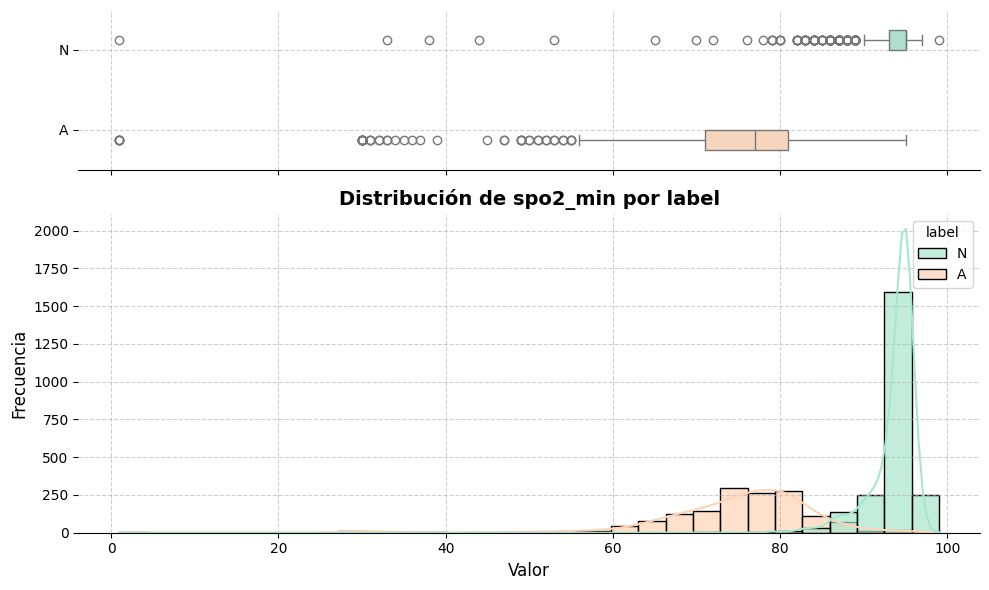

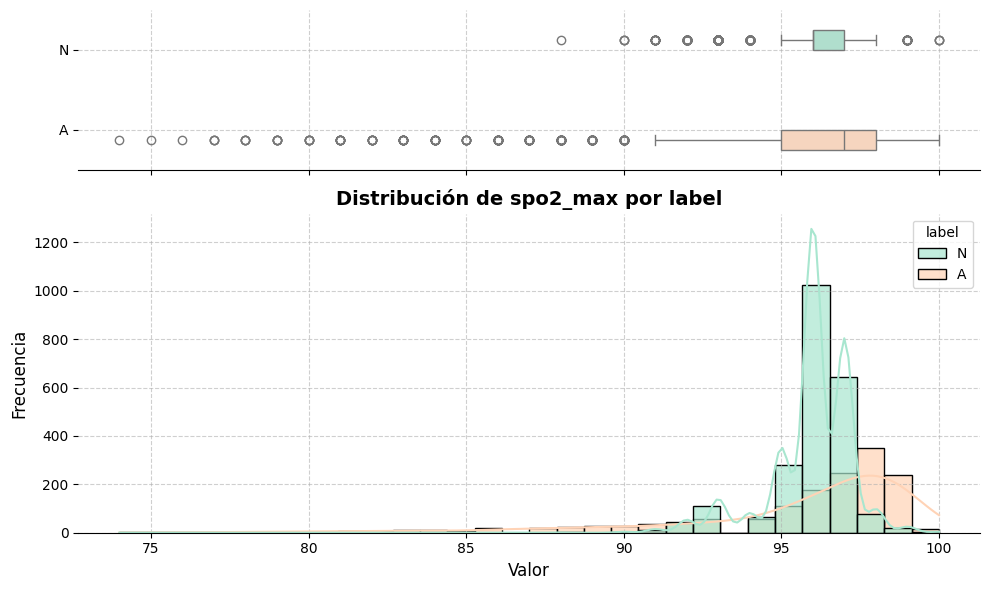

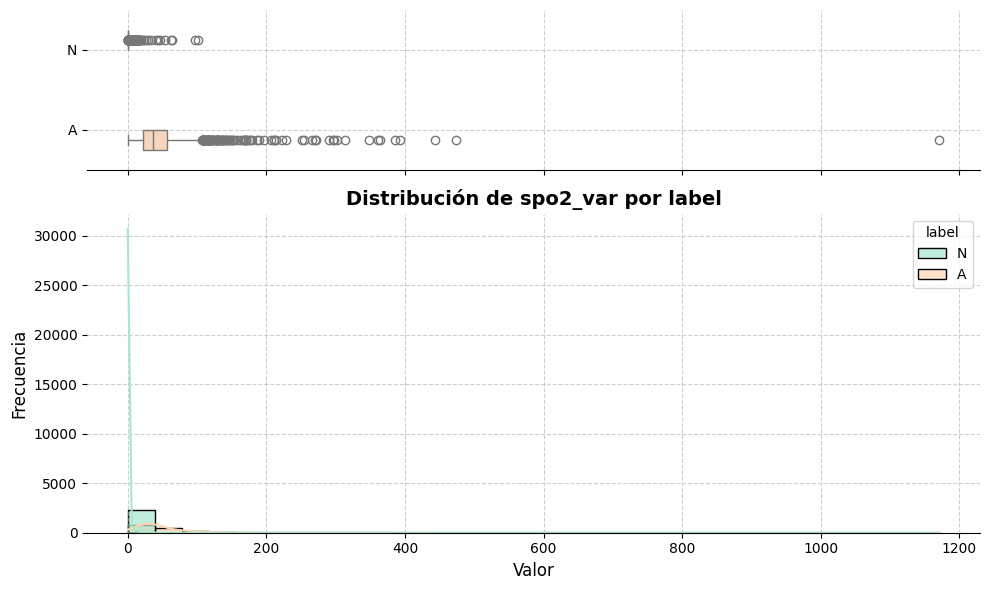

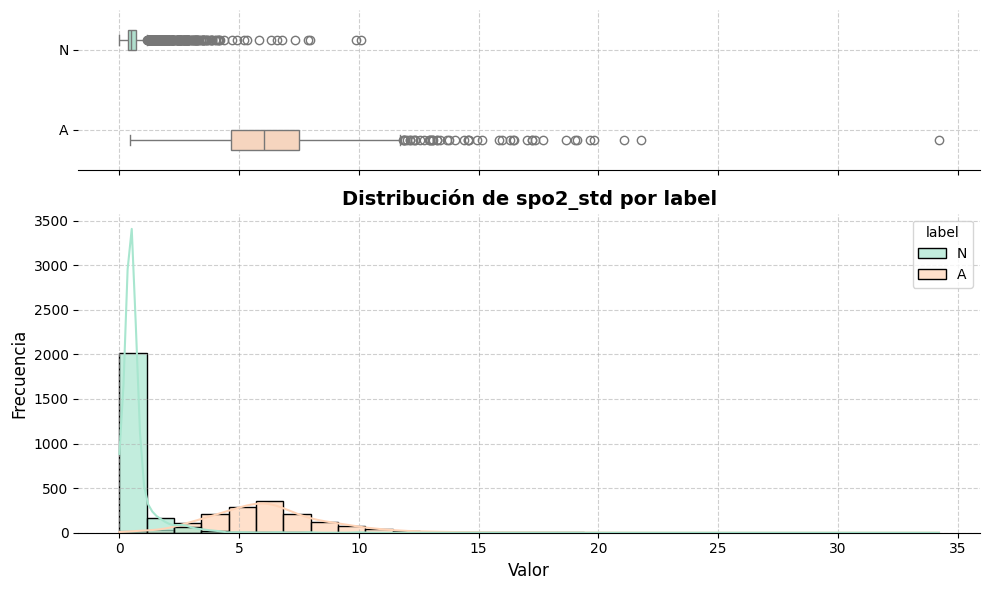

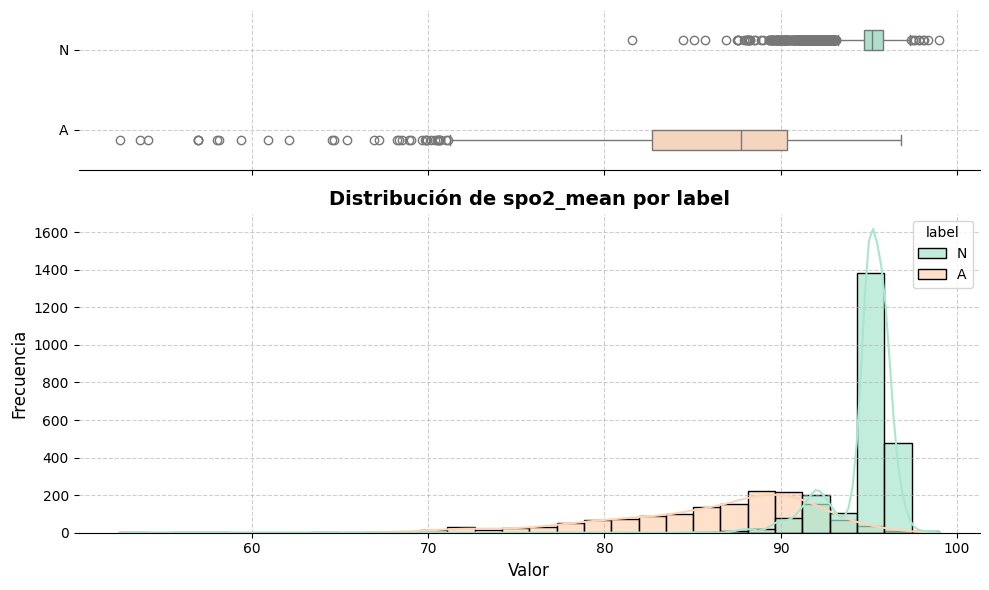

In [23]:
features = ['spo2_min','spo2_max','spo2_var','spo2_std','spo2_mean']  
plot_variable_by_group(df, features,'label', 'SPO2', num_bins=30)

#### ***Análisis***

Para el análisis bivariado de la saturación de oxígeno (SpO₂) se consideraron las características spo2_min, spo2_max, spo2_var, spo2_std y spo2_mean, en conjunto con la variable label, que permite diferenciar entre las épocas con eventos de apnea y aquellas sin alteraciones respiratorias.

En las características de mínimo (spo2_min) se observa que las épocas sin eventos respiratorios presentan valores concentrados alrededor de 95%, consistentes con los rangos fisiológicos normales de saturación de oxígeno, los cuales se sitúan típicamente entre 96% y 100% [14]. En contraste, las épocas con eventos de apnea exhiben un rango intercuartílico más amplio, con valores mínimos que oscilan aproximadamente entre 70% y 80%, lo cual refleja la desaturación transitoria característica de los episodios de apnea.

Respecto a las características de máximo (spo2_max), ambos grupos —con y sin eventos— presentan valores comprendidos entre 95% y 100%, sin diferencias marcadas en los valores centrales. No obstante, el grupo con eventos de apnea muestra una mayor dispersión, evidenciada en un rango intercuartílico más extenso, lo cual sugiere fluctuaciones más pronunciadas en la saturación máxima alcanzada durante dichas épocas.

En las características de varianza (spo2_var) y desviación estándar (spo2_std) las épocas sin eventos respiratorios presentan valores concentrados en torno a cero, lo que indica estabilidad en la saturación. Por el contrario, las épocas con eventos de apnea muestran una mayor dispersión, especialmente en la desviación estándar, cuya mediana alcanza aproximadamente 5, mientras que en las épocas sin eventos este valor se aproxima a 0. Este comportamiento refleja la variabilidad significativa de la señal de SpO₂ durante los episodios de apnea, asociada a los ciclos de desaturación y resaturación típicos de la interrupción respiratoria.

En cuanto a la media (spo2_mean), las épocas sin eventos presentan valores predominantemente cercanos a 95%, consistentes con una oxigenación estable, mientras que las épocas con apnea exhiben valores más dispersos, con un rango intercuartílico comprendido entre 80% y 90%, reflejando nuevamente el impacto de las desaturaciones en el valor promedio.

Finalmente, se identificaron valores atípicos en todas las características analizadas. Algunos de estos presentan valores inferiores al 70%, los cuales carecen de interpretación fisiológica confiable, ya que, aunque la hipoxemia se define como una saturación menor al 90%, los pulsioxímetros están calibrados típicamente para un rango de 70% a 100%, con una precisión entre 2% y 4% [16]. Por tanto, valores por debajo del 70% no representan mediciones fiables, sino que se encuentran fuera del rango de calibración del instrumento, y, en consecuencia, no poseen un significado fisiológico interpretable.


### <span style="color:#1a73e8;"><strong>FLUJO</strong></span>


DISTRIBUCIÓN Y VARIABILIDAD DE LAS VARIABLES FLUJO POR LABEL



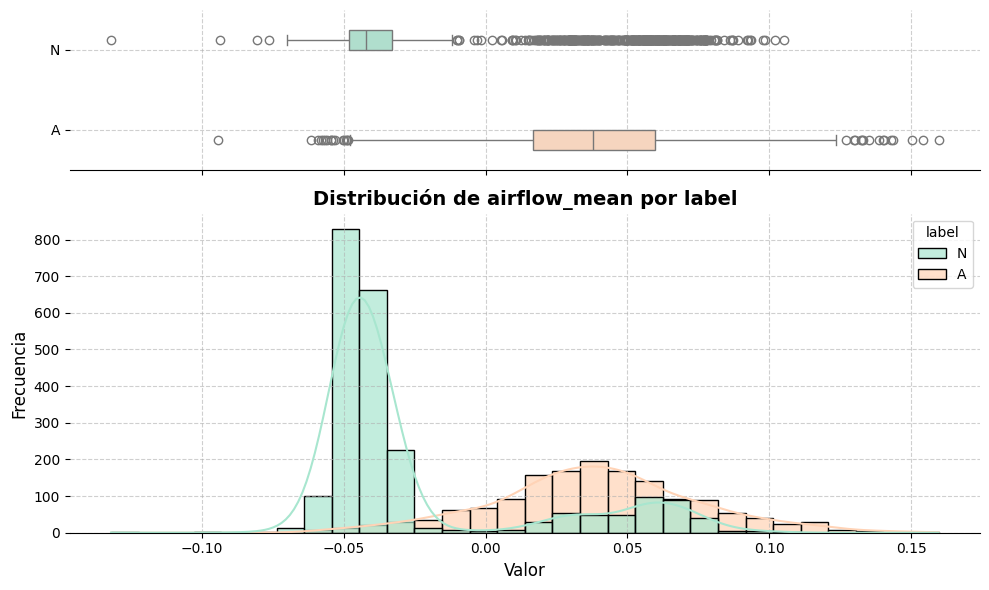

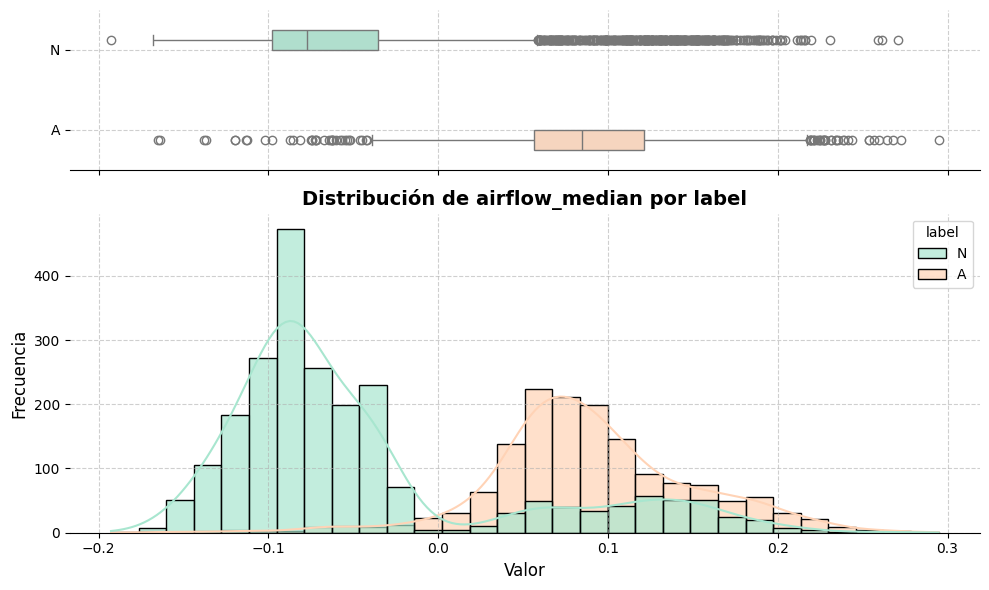

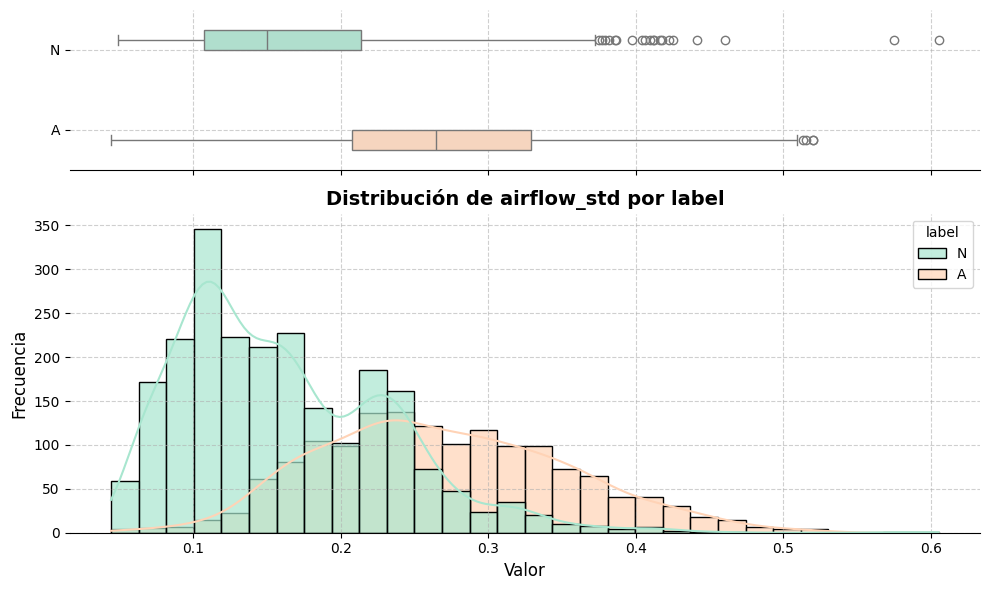

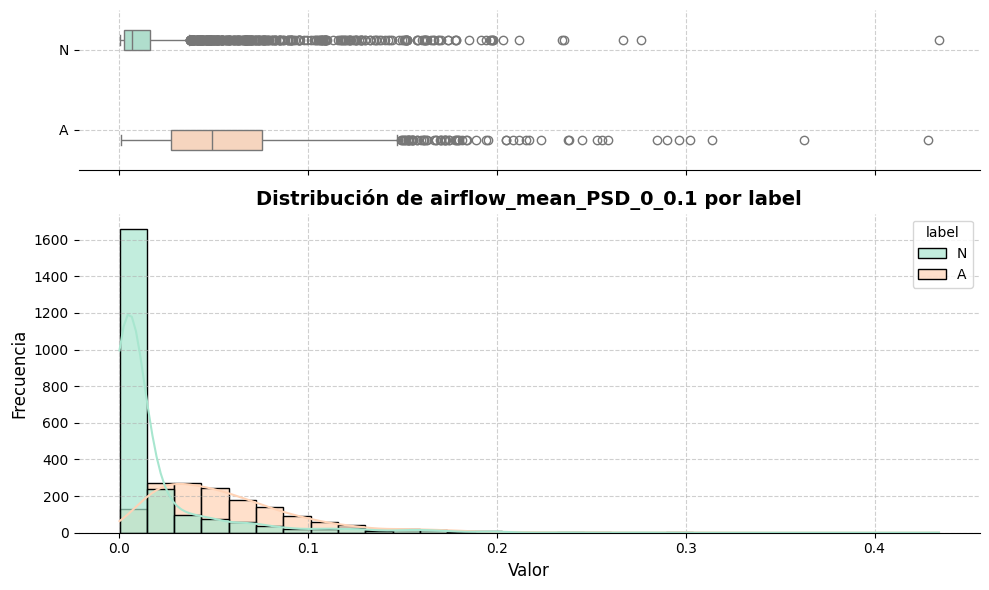

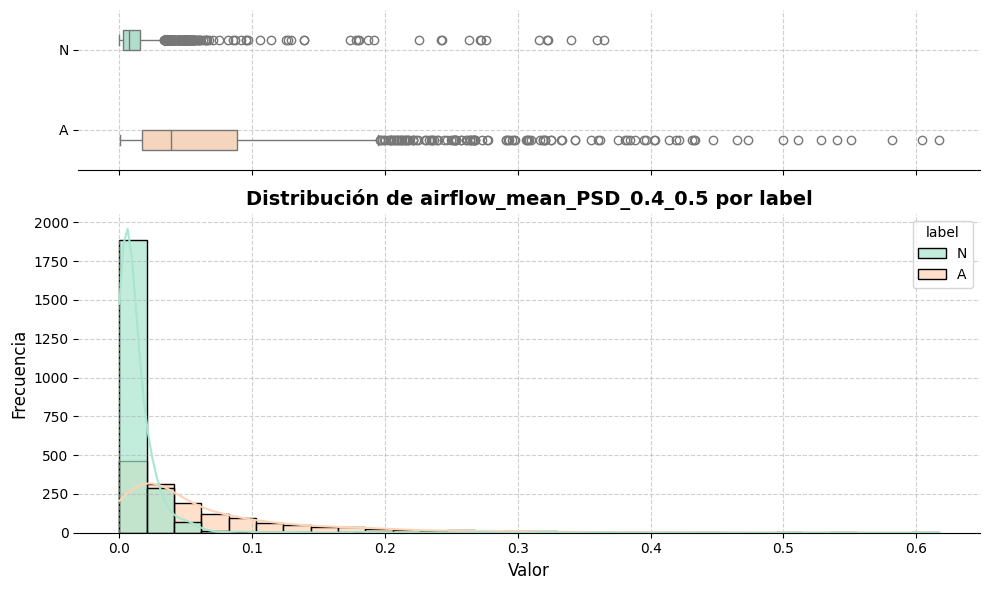

In [24]:
features = ['airflow_mean','airflow_median','airflow_std','airflow_mean_PSD_0_0.1','airflow_mean_PSD_0.4_0.5']  
plot_variable_by_group(df, features,'label', 'FLUJO', num_bins=30)

#### ***Análisis***

En el análisis bivariado de la señal de flujo respiratorio se evaluaron las características airflow_mean, airflow_median, airflow_std, y las componentes frecuenciales airflow_mean_PSD_0_0.1 y airflow_mean_PSD_0_4_0.5, considerando adicionalmente la variable label, que distingue entre épocas con eventos de apnea (A) y épocas sin eventos respiratorios (N).

En las características de tendencia central (mean y median) se observa un desplazamiento de las medianas hacia valores próximos a cero o ligeramente positivos en las épocas con apnea (≈0.04 para el promedio y ≈0.08 para la mediana), en contraste con valores negativos en las épocas sin eventos (≈–0.05 y ≈–0.1, respectivamente). Este desplazamiento se explica por el tiempo prolongado durante el cual la señal de flujo permanece cercana a cero en presencia de apnea, debido a la interrupción o reducción significativa del intercambio de aire. En consecuencia, la mayor parte de la época presenta valores próximos a cero o levemente positivos, como se evidencia en la Figura 1. En cambio, durante las épocas sin eventos respiratorios, la señal exhibe oscilaciones amplias y aproximadamente simétricas entre –0.6 y 0.6, reflejando un patrón respiratorio normal con alternancia rítmica entre las fases de inspiración y espiración, como se observa en la Figura 2.

En la característica airflow_std, la dispersión de los datos es mayor en las épocas con apnea, con un rango intercuartílico aproximado entre 0.2 y 0.3, frente a 0.1–0.2 en las épocas normales. Este aumento de la variabilidad se asocia a la transición entre el cese del flujo y la fase de recuperación ventilatoria, en la que se producen picos de flujo más marcados tras la reanudación del esfuerzo respiratorio.

Las características frecuenciales (airflow_mean_PSD_0_0.1 y airflow_mean_PSD_0_4_0.5) muestran una mayor dispersión en las épocas con eventos respiratorios, mientras que en las épocas sin eventos los valores permanecen próximos a cero. Esto sugiere que los episodios de apnea modifican la distribución espectral del flujo, con un incremento relativo de la energía en determinadas bandas de frecuencia debido a la irregularidad y fragmentación del patrón ventilatorio.

Finalmente, se observan valores atípicos en todas las variables, especialmente en las frecuenciales, con algunos superiores a 0.4 para PSD_0_0.1 y a 0.6 para PSD_0_4_0.5. Estos valores extremos pueden corresponder a transiciones abruptas entre apnea y ventilación, o a artefactos transitorios.

### ***Matriz de correlación***

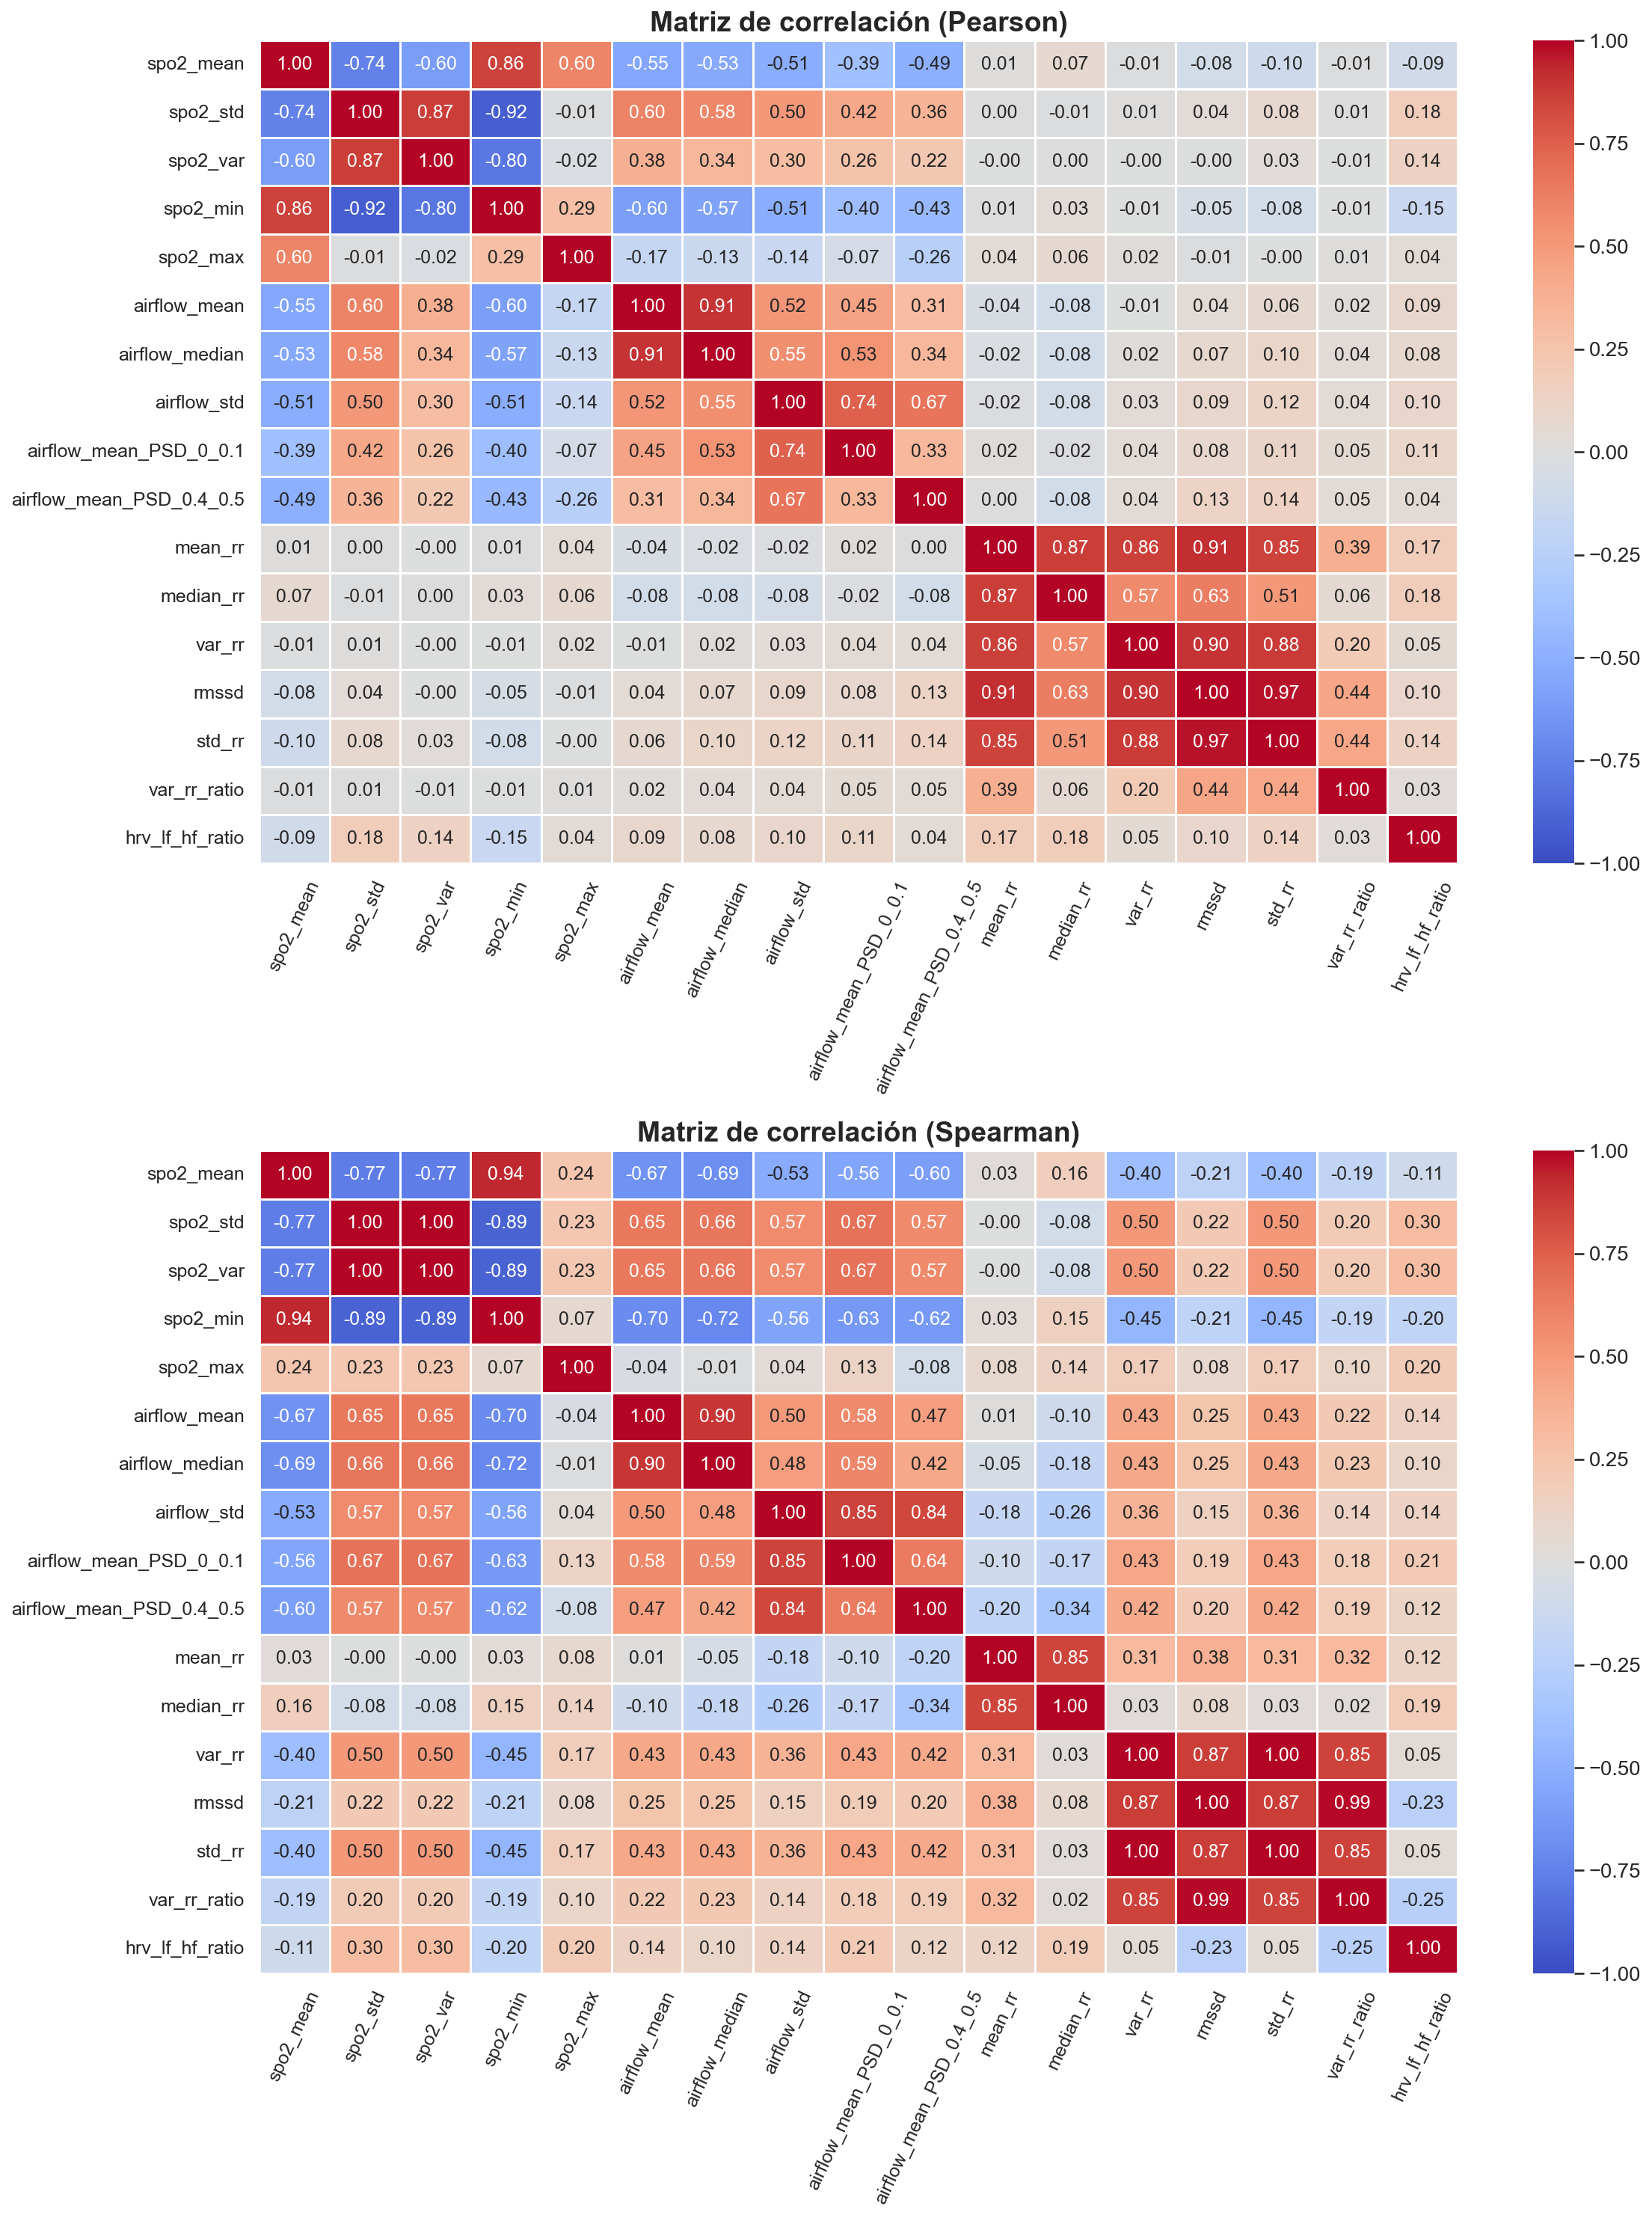

🔹 Correlaciones Pearson > 0.8:


,Variable 1,Variable 2,Correlación
130,rmssd,std_rr,0.970725
117,mean_rr,rmssd,0.914915
70,airflow_mean,airflow_median,0.905117
126,var_rr,rmssd,0.904953
127,var_rr,std_rr,0.876854
115,mean_rr,median_rr,0.872397
16,spo2_std,spo2_var,0.868399
116,mean_rr,var_rr,0.859496
2,spo2_mean,spo2_min,0.855978
118,mean_rr,std_rr,0.854106



🔹 Correlaciones Spearman > 0.8:


,Variable 1,Variable 2,Correlación
16,spo2_std,spo2_var,1.000000
127,var_rr,std_rr,1.000000
131,rmssd,var_rr_ratio,0.990253
2,spo2_mean,spo2_min,0.935278
70,airflow_mean,airflow_median,0.895298
130,rmssd,std_rr,0.873393
126,var_rr,rmssd,0.873393
91,airflow_std,airflow_mean_PSD_0_0.1,0.854325
133,std_rr,var_rr_ratio,0.851734
128,var_rr,var_rr_ratio,0.851734


In [25]:
# --- Seleccionar columnas numéricas ---
df_num = df.select_dtypes(include=['float64', 'int64'])

# --- Calcular matrices de correlación ---
corr_pearson = df_num.corr(method='pearson')
corr_spearman = df_num.corr(method='spearman')

# --- Función para extraer correlaciones > 0.8 ---
def high_correlations(corr_matrix, threshold=0.8):
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
    return corr_pairs[abs(corr_pairs['Correlación']) > threshold].sort_values(
        by='Correlación', ascending=False
    )

# --- Filtrar correlaciones altas ---
high_corr_pearson = high_correlations(corr_pearson)
high_corr_spearman = high_correlations(corr_spearman)

# --- Configuración estética general ---
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.dpi'] = 150

# --- Figura con dos subgráficos (una columna) ---
fig, axes = plt.subplots(2, 1, figsize=(16, 20))

# --- Mapa de calor Pearson ---
sns.heatmap(
    corr_pearson, annot=True, fmt=".2f", cmap="coolwarm",
    cbar=True, square=False, linewidths=0.5,
    ax=axes[0], vmin=-1, vmax=1,
    annot_kws={"size": 12}
)
axes[0].set_title("Matriz de correlación (Pearson)", fontsize=18, fontweight="bold")
axes[0].tick_params(axis='x', rotation=65, labelsize=12)
axes[0].tick_params(axis='y', rotation=0, labelsize=12)

# --- Mapa de calor Spearman ---
sns.heatmap(
    corr_spearman, annot=True, fmt=".2f", cmap="coolwarm",
    cbar=True, square=False, linewidths=0.5,
    ax=axes[1], vmin=-1, vmax=1,
    annot_kws={"size": 12}
)
axes[1].set_title("Matriz de correlación (Spearman)", fontsize=18, fontweight="bold")
axes[1].tick_params(axis='x', rotation=65, labelsize=12)
axes[1].tick_params(axis='y', rotation=0, labelsize=12)

plt.tight_layout()
plt.show()

# --- Mostrar correlaciones altas ---
print("🔹 Correlaciones Pearson > 0.8:")
display(high_corr_pearson)

print("\n🔹 Correlaciones Spearman > 0.8:")
display(high_corr_spearman)

#### ***Análisis***

Con el objetivo de identificar relaciones lineales y monótonas entre las características extraídas, se aplicaron los coeficientes de correlación de Pearson y Spearman. En la matriz de correlación de Pearson, se identificaron asociaciones altas (r > 0.8) entre múltiples características. Destaca la correlación entre rmssd y std_rr (r = 0.97), lo que evidencia que ambas cuantifican de manera equivalente la variabilidad del ritmo cardíaco (HRV), reflejando la magnitud de las fluctuaciones de los intervalos RR entre latidos consecutivos. Asimismo, las correlaciones elevadas entre mean_rr, std_rr, rmssd y var_rr (todas superiores a 0.85) confirman que estas métricas están fuertemente interrelacionadas, ya que describen diferentes aspectos estadísticos de la misma dinámica cardíaca. 

En relación con las características derivadas del flujo respiratorio, se observa una correlación alta entre airflow_mean y airflow_median (r = 0.9), lo que indica que ambas variables describen comportamientos muy similares del flujo promedio en las distintas épocas. En el caso de la saturación de oxígeno, la fuerte relación entre spo2_std y spo2_var (r = 0.87) se explica por la dependencia matemática entre ambas medidas de dispersión. Además, la correlación negativa entre spo2_std y spo2_min (r = -0.92) señala que a mayor variabilidad en la señal de SpO₂, menores son los valores mínimos alcanzados, lo que refleja desaturaciones más pronunciadas durante los episodios de apnea.

La correlación de Spearman refuerza los patrones observados, evidenciando asociaciones monótonas igualmente elevadas. Se registraron correlaciones perfectas (ρ = 1.0) entre spo2_std y spo2_var, así como entre var_rr y std_rr, lo que refleja una estrecha relación estadística entre estas métricas, dado que ambas describen propiedades de dispersión derivadas de la misma señal. De manera consistente, la correlación alta entre rmssd y var_rr_ratio (ρ = 0.99), junto con la observada entre mean_rr y median_rr (ρ = 0.85), demuestra la consistencia interna de las medidas de variabilidad cardíaca calculadas a partir de los intervalos RR. Asimismo, las correlaciones positivas entre airflow_std y las componentes espectrales airflow_mean_PSD_0_0.1 (ρ = 0.85) y airflow_mean_PSD_0.4_0.5 (ρ = 0.84) indican que los incrementos en la variabilidad del flujo respiratorio se asocian con mayores fluctuaciones energéticas en las bandas de baja y alta frecuencia. Finalmente, las correlaciones negativas entre spo2_std, spo2_var y spo2_min (ρ = -0.89) confirman que una mayor dispersión en la saturación de oxígeno tiende a coincidir con descensos más pronunciados en los valores mínimos de SpO₂, reflejando los efectos característicos de las desaturaciones durante los eventos de apnea.

En conjunto, los resultados evidencian una alta redundancia entre las métricas derivadas del ritmo cardíaco y de la saturación de oxígeno, así como entre las medidas temporales y espectrales del flujo respiratorio. Este comportamiento indica que varias de las características analizadas describen los mismos procesos fisiológicos o responden a variaciones comunes, lo que reduce su capacidad de aportar información independiente. Por tanto, en etapas posteriores será necesario aplicar técnicas de selección o reducción de características orientadas a eliminar la redundancia y conservar únicamente las variables más informativas y fisiológicamente relevantes.

## <span style="color:#1a73e8;"><strong>Conclusiones</strong></span>

- El análisis de la base de datos Apnea-ECG evidencia que las métricas temporales y frecuenciales extraídas del ECG, la saturación de oxígeno (SpO₂) y el flujo respiratorio reflejan adecuadamente los patrones fisiológicos asociados a la apnea del sueño. En particular, las épocas con eventos respiratorios muestran desaturaciones transitorias de oxígeno, caracterizadas por disminuciones en spo2_min y spo2_mean y aumentos en spo2_std y spo2_var, mientras que la señal de flujo respiratorio presenta medianas cercanas a cero y mayor variabilidad. Estos hallazgos confirman la capacidad de las métricas extraídas para diferenciar, en términos generales, entre épocas con y sin apnea.

- Se observó alta correlación entre variables relacionadas (RMSSD y std_rr: ρ = 0.97; airflow_mean y airflow_median: ρ = 0.9; spo2_std y spo2_var: ρ = 1.0), evidenciando redundancia y sugiriendo la necesidad de seleccionar las características más representativas.

- A pesar de que los resultados reflejan patrones fisiológicos consistentes, la muestra presenta un sesgo de género marcado (7 hombres y 1 mujer), lo que limita la generalización de los hallazgos a poblaciones más amplias y heterogéneas



## <span style="color:#1a73e8;"><strong>Referencias</strong></span>

[1]	N. Canessa et al., «Obstructive sleep apnea: brain structural changes and neurocognitive function before and after treatment», Am. J. Respir. Crit. Care Med., vol. 183, n.o 10, pp. 1419-1426, may 2011, doi: 10.1164/rccm.201005-0693OC.

[2]	D. Valecchi et al., «Prognostic Significance of Obstructive Sleep Apnea in a Population of Subjects with Interstitial Lung Diseases», Pulm. Ther., vol. 9, n.o 2, pp. 223-236, feb. 2023, doi: 10.1007/s41030-023-00215-1.

[3]	S. Bottia, H. Barrios-Bermúdez, y D. Rosselli, «Prevalencia de apnea de sueño en Colombia: un análisis de las bases de datos del Ministerio de Salud», Iatreia, vol. 37, n.o 1, Art. n.o 1, 2024, doi: 10.17533/udea.iatreia.222.

[4]	S. Surani y P. Taweesedt, «Obstructive Sleep Apnea: New Perspective», Medicina (Mex.), vol. 59, n.o 1, p. 75, dic. 2022, doi: 10.3390/medicina59010075.

[5]	K. G. Johnson y D. C. Johnson, «Treatment of sleep-disordered breathing with positive airway pressure devices: technology update», Med. Devices Auckl. NZ, vol. 8, pp. 425-437, 2015, doi: 10.2147/MDER.S70062.

[6]	P. K. Tyagi y D. Agrawal, «Automatic detection of sleep apnea from a single-lead ECG signal based on spiking neural network model», Comput. Biol. Med., vol. 179, p. 108877, sep. 2024, doi: 10.1016/j.compbiomed.2024.108877.

[7]	M. P. Ayalew, H. D. Nemomssa, y G. L. Simegn, «Sleep apnea syndrome detection and classification of severity level from ECG and SpO2 signals», Health Technol., vol. 5, n.o 0, Art. n.o 0, nov. 2021, doi: 10.21037/ht-21-18.

[8]	T. Penzel, G. B. Moody, R. G. Mark, A. L. Goldberger, y J. H. Peter, «Apnea-ECG Database». physionet.org, 2000. doi: 10.13026/C23W2R.

[9]	D. Valecchi et al., «Prognostic Significance of Obstructive Sleep Apnea in a Population of Subjects with Interstitial Lung Diseases», Pulm. Ther., vol. 9, n.o 2, pp. 223-236, feb. 2023, doi: 10.1007/s41030-023-00215-1.

[10]	T. Wang, C. Lu, y G. Shen, «Detection of Sleep Apnea from Single-Lead ECG Signal Using a Time Window Artificial Neural Network», BioMed Res. Int., vol. 2019, p. 9768072, dic. 2019, doi: 10.1155/2019/9768072.

[11]	M. P. Ayalew, H. D. Nemomssa, y G. L. Simegn, «Sleep apnea syndrome detection and classification of severity level from ECG and SpO2 signals», Health Technol., vol. 5, n.o 0, nov. 2021, doi: 10.21037/ht-21-18.

[12]	X. Li, S. Ling, y S. Su, «A Hybrid Feature Selection and Extraction Methods for Sleep Apnea Detection Using Bio-Signals», Sensors, vol. 20, p. 4323, ago. 2020, doi: 10.3390/s20154323.

[13]	K. Narkiewicz, N. Montano, C. Cogliati, P. J. H. van de Borne, M. E. Dyken, y V. K. Somers, «Altered Cardiovascular Variability in Obstructive Sleep Apnea», Circulation, vol. 98, n.o 11, pp. 1071-1077, sep. 1998, doi: 10.1161/01.CIR.98.11.1071.

[14]	N. H. Hoang y Z. Liang, «Detection and Severity Classification of Sleep Apnea Using Continuous Wearable SpO2 Signals: A Multi-Scale Feature Approach», Sensors, vol. 25, n.o 6, p. 1698, ene. 2025, doi: 10.3390/s25061698.

[15]	T. Lyu et al., «Assessment of the long RR intervals using convolutional neural networks in single-lead long-term Holter electrocardiogram recordings», Sci. Rep., vol. 15, n.o 1, p. 11912, abr. 2025, doi: 10.1038/s41598-025-96622-2.

[16]	K. D. Torp, P. Modi, E. J. Pollard, y L. V. Simon, «Pulse Oximetry», en StatPearls, Treasure Island (FL): StatPearls Publishing, 2025. Accedido: 6 de octubre de 2025. [En línea]. Disponible en: http://www.ncbi.nlm.nih.gov/books/NBK470348/
